# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Plot Style

In [3]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd() / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Erzeugnung des Moduls

In [4]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [5]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [6]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [7]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [8]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [9]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [10]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.1636
Epoch 1/200, Iteration 2/12, Loss: 0.3356
Epoch 1/200, Iteration 3/12, Loss: 0.8173
Epoch 1/200, Iteration 4/12, Loss: 0.2642
Epoch 1/200, Iteration 5/12, Loss: 0.1986
Epoch 1/200, Iteration 6/12, Loss: 0.4450
Epoch 1/200, Iteration 7/12, Loss: 0.3632
Epoch 1/200, Iteration 8/12, Loss: 0.2002
Epoch 1/200, Iteration 9/12, Loss: 0.1232
Epoch 1/200, Iteration 10/12, Loss: 0.0963
Epoch 1/200, Iteration 11/12, Loss: 0.0945
Epoch 1/200, Iteration 12/12, Loss: 0.1808
Epoch 1/200, Iteration 13/12, Loss: 0.0939
Train Error: 
 Accuracy: 51.62%, Avg loss: 0.080621, MRE: 0.152803, MAE: 0.032862 

Test Error: 
 Accuracy: 47.0%, Avg loss: 0.085435, MRE: 0.139439, MAE: 0.033797 

Epoch 2/200, Iteration 1/12, Loss: 0.0782
Epoch 2/200, Iteration 2/12, Loss: 0.0863
Epoch 2/200, Iteration 3/12, Loss: 0.0922
Epoch 2/200, Iteration 4/12, Loss: 0.1259
Epoch 2/200, Iteration 5/12, Loss: 0.0767
Epoch 2/200, Iteration 6/12, Loss: 0.0964
Epoch 2/200, Iteration 7/12, Los

Epoch 12/200, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001927, MRE: 0.022679, MAE: 0.003846 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.001938, MRE: 0.017866, MAE: 0.004080 

Epoch 13/200, Iteration 1/12, Loss: 0.0022
Epoch 13/200, Iteration 2/12, Loss: 0.0015
Epoch 13/200, Iteration 3/12, Loss: 0.0015
Epoch 13/200, Iteration 4/12, Loss: 0.0022
Epoch 13/200, Iteration 5/12, Loss: 0.0015
Epoch 13/200, Iteration 6/12, Loss: 0.0029
Epoch 13/200, Iteration 7/12, Loss: 0.0011
Epoch 13/200, Iteration 8/12, Loss: 0.0043
Epoch 13/200, Iteration 9/12, Loss: 0.0012
Epoch 13/200, Iteration 10/12, Loss: 0.0037
Epoch 13/200, Iteration 11/12, Loss: 0.0054
Epoch 13/200, Iteration 12/12, Loss: 0.0018
Epoch 13/200, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.003394, MRE: 0.028986, MAE: 0.005878 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003003, MRE: 0.026286, MAE: 0.005521 

Epoch 14/200, Iteration 1/12, Loss: 0.0032
Epoch 14/200, Itera

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.003530, MRE: 0.026850, MAE: 0.005705 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002379, MRE: 0.020419, MAE: 0.004786 

Epoch 25/200, Iteration 1/12, Loss: 0.0027
Epoch 25/200, Iteration 2/12, Loss: 0.0103
Epoch 25/200, Iteration 3/12, Loss: 0.0045
Epoch 25/200, Iteration 4/12, Loss: 0.0120
Epoch 25/200, Iteration 5/12, Loss: 0.0067
Epoch 25/200, Iteration 6/12, Loss: 0.0054
Epoch 25/200, Iteration 7/12, Loss: 0.0055
Epoch 25/200, Iteration 8/12, Loss: 0.0049
Epoch 25/200, Iteration 9/12, Loss: 0.0068
Epoch 25/200, Iteration 10/12, Loss: 0.0055
Epoch 25/200, Iteration 11/12, Loss: 0.0050
Epoch 25/200, Iteration 12/12, Loss: 0.0076
Epoch 25/200, Iteration 13/12, Loss: 0.0036
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.005578, MRE: 0.041519, MAE: 0.008906 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.004440, MRE: 0.031854, MAE: 0.007821 

Epoch 26/200, Iteration 1/12, Loss: 0.0066
Epoch 26/200, Iteration 2/12, Loss: 0.0056
Epoch 26/200, Iter

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000146, MRE: 0.007186, MAE: 0.001072 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000159, MRE: 0.005249, MAE: 0.001129 

Epoch 37/200, Iteration 1/12, Loss: 0.0001
Epoch 37/200, Iteration 2/12, Loss: 0.0001
Epoch 37/200, Iteration 3/12, Loss: 0.0002
Epoch 37/200, Iteration 4/12, Loss: 0.0001
Epoch 37/200, Iteration 5/12, Loss: 0.0001
Epoch 37/200, Iteration 6/12, Loss: 0.0002
Epoch 37/200, Iteration 7/12, Loss: 0.0002
Epoch 37/200, Iteration 8/12, Loss: 0.0002
Epoch 37/200, Iteration 9/12, Loss: 0.0002
Epoch 37/200, Iteration 10/12, Loss: 0.0001
Epoch 37/200, Iteration 11/12, Loss: 0.0001
Epoch 37/200, Iteration 12/12, Loss: 0.0001
Epoch 37/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000156, MRE: 0.007150, MAE: 0.001072 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000164, MRE: 0.005342, MAE: 0.001188 

Epoch 38/200, Iteration 1/12, Loss: 0.0001
Epoch 38/200, Iteration 2/12, Loss: 0.0002
Epoch 38/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000109, MRE: 0.006660, MAE: 0.000940 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000118, MRE: 0.004665, MAE: 0.000986 

Epoch 49/200, Iteration 1/12, Loss: 0.0001
Epoch 49/200, Iteration 2/12, Loss: 0.0001
Epoch 49/200, Iteration 3/12, Loss: 0.0001
Epoch 49/200, Iteration 4/12, Loss: 0.0001
Epoch 49/200, Iteration 5/12, Loss: 0.0001
Epoch 49/200, Iteration 6/12, Loss: 0.0001
Epoch 49/200, Iteration 7/12, Loss: 0.0001
Epoch 49/200, Iteration 8/12, Loss: 0.0001
Epoch 49/200, Iteration 9/12, Loss: 0.0001
Epoch 49/200, Iteration 10/12, Loss: 0.0002
Epoch 49/200, Iteration 11/12, Loss: 0.0001
Epoch 49/200, Iteration 12/12, Loss: 0.0001
Epoch 49/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.006798, MAE: 0.000921 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000120, MRE: 0.004745, MAE: 0.000964 

Epoch 50/200, Iteration 1/12, Loss: 0.0002
Epoch 50/200, Iteration 2/12, Loss: 0.0001
Epoch 50/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000092, MRE: 0.006406, MAE: 0.000831 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000109, MRE: 0.004726, MAE: 0.000885 

Epoch 61/200, Iteration 1/12, Loss: 0.0001
Epoch 61/200, Iteration 2/12, Loss: 0.0001
Epoch 61/200, Iteration 3/12, Loss: 0.0002
Epoch 61/200, Iteration 4/12, Loss: 0.0001
Epoch 61/200, Iteration 5/12, Loss: 0.0001
Epoch 61/200, Iteration 6/12, Loss: 0.0002
Epoch 61/200, Iteration 7/12, Loss: 0.0001
Epoch 61/200, Iteration 8/12, Loss: 0.0001
Epoch 61/200, Iteration 9/12, Loss: 0.0001
Epoch 61/200, Iteration 10/12, Loss: 0.0001
Epoch 61/200, Iteration 11/12, Loss: 0.0001
Epoch 61/200, Iteration 12/12, Loss: 0.0001
Epoch 61/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000085, MRE: 0.006100, MAE: 0.000799 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000095, MRE: 0.004185, MAE: 0.000838 

Epoch 62/200, Iteration 1/12, Loss: 0.0000
Epoch 62/200, Iteration 2/12, Loss: 0.0001
Epoch 62/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000072, MRE: 0.005896, MAE: 0.000732 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000084, MRE: 0.003973, MAE: 0.000767 

Epoch 73/200, Iteration 1/12, Loss: 0.0001
Epoch 73/200, Iteration 2/12, Loss: 0.0001
Epoch 73/200, Iteration 3/12, Loss: 0.0001
Epoch 73/200, Iteration 4/12, Loss: 0.0000
Epoch 73/200, Iteration 5/12, Loss: 0.0001
Epoch 73/200, Iteration 6/12, Loss: 0.0001
Epoch 73/200, Iteration 7/12, Loss: 0.0001
Epoch 73/200, Iteration 8/12, Loss: 0.0001
Epoch 73/200, Iteration 9/12, Loss: 0.0001
Epoch 73/200, Iteration 10/12, Loss: 0.0001
Epoch 73/200, Iteration 11/12, Loss: 0.0001
Epoch 73/200, Iteration 12/12, Loss: 0.0000
Epoch 73/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000071, MRE: 0.005673, MAE: 0.000737 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000075, MRE: 0.003814, MAE: 0.000743 

Epoch 74/200, Iteration 1/12, Loss: 0.0001
Epoch 74/200, Iteration 2/12, Loss: 0.0001
Epoch 74/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000062, MRE: 0.005492, MAE: 0.000682 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000073, MRE: 0.003635, MAE: 0.000700 

Epoch 85/200, Iteration 1/12, Loss: 0.0001
Epoch 85/200, Iteration 2/12, Loss: 0.0001
Epoch 85/200, Iteration 3/12, Loss: 0.0000
Epoch 85/200, Iteration 4/12, Loss: 0.0001
Epoch 85/200, Iteration 5/12, Loss: 0.0001
Epoch 85/200, Iteration 6/12, Loss: 0.0000
Epoch 85/200, Iteration 7/12, Loss: 0.0001
Epoch 85/200, Iteration 8/12, Loss: 0.0001
Epoch 85/200, Iteration 9/12, Loss: 0.0001
Epoch 85/200, Iteration 10/12, Loss: 0.0001
Epoch 85/200, Iteration 11/12, Loss: 0.0001
Epoch 85/200, Iteration 12/12, Loss: 0.0001
Epoch 85/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000061, MRE: 0.005519, MAE: 0.000690 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000072, MRE: 0.003758, MAE: 0.000730 

Epoch 86/200, Iteration 1/12, Loss: 0.0001
Epoch 86/200, Iteration 2/12, Loss: 0.0001
Epoch 86/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000057, MRE: 0.005316, MAE: 0.000667 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000055, MRE: 0.003391, MAE: 0.000667 

Epoch 97/200, Iteration 1/12, Loss: 0.0001
Epoch 97/200, Iteration 2/12, Loss: 0.0001
Epoch 97/200, Iteration 3/12, Loss: 0.0001
Epoch 97/200, Iteration 4/12, Loss: 0.0000
Epoch 97/200, Iteration 5/12, Loss: 0.0000
Epoch 97/200, Iteration 6/12, Loss: 0.0001
Epoch 97/200, Iteration 7/12, Loss: 0.0001
Epoch 97/200, Iteration 8/12, Loss: 0.0001
Epoch 97/200, Iteration 9/12, Loss: 0.0000
Epoch 97/200, Iteration 10/12, Loss: 0.0001
Epoch 97/200, Iteration 11/12, Loss: 0.0001
Epoch 97/200, Iteration 12/12, Loss: 0.0000
Epoch 97/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000064, MRE: 0.005470, MAE: 0.000688 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000055, MRE: 0.003312, MAE: 0.000646 

Epoch 98/200, Iteration 1/12, Loss: 0.0000
Epoch 98/200, Iteration 2/12, Loss: 0.0001
Epoch 98/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000045, MRE: 0.005000, MAE: 0.000594 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000055, MRE: 0.003401, MAE: 0.000610 

Epoch 109/200, Iteration 1/12, Loss: 0.0000
Epoch 109/200, Iteration 2/12, Loss: 0.0001
Epoch 109/200, Iteration 3/12, Loss: 0.0000
Epoch 109/200, Iteration 4/12, Loss: 0.0000
Epoch 109/200, Iteration 5/12, Loss: 0.0000
Epoch 109/200, Iteration 6/12, Loss: 0.0000
Epoch 109/200, Iteration 7/12, Loss: 0.0001
Epoch 109/200, Iteration 8/12, Loss: 0.0001
Epoch 109/200, Iteration 9/12, Loss: 0.0001
Epoch 109/200, Iteration 10/12, Loss: 0.0000
Epoch 109/200, Iteration 11/12, Loss: 0.0000
Epoch 109/200, Iteration 12/12, Loss: 0.0001
Epoch 109/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.004874, MAE: 0.000582 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000051, MRE: 0.003194, MAE: 0.000625 

Epoch 110/200, Iteration 1/12, Loss: 0.0000
Epoch 110/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.004597, MAE: 0.000550 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000046, MRE: 0.002857, MAE: 0.000615 

Epoch 121/200, Iteration 1/12, Loss: 0.0000
Epoch 121/200, Iteration 2/12, Loss: 0.0000
Epoch 121/200, Iteration 3/12, Loss: 0.0001
Epoch 121/200, Iteration 4/12, Loss: 0.0001
Epoch 121/200, Iteration 5/12, Loss: 0.0001
Epoch 121/200, Iteration 6/12, Loss: 0.0000
Epoch 121/200, Iteration 7/12, Loss: 0.0000
Epoch 121/200, Iteration 8/12, Loss: 0.0001
Epoch 121/200, Iteration 9/12, Loss: 0.0001
Epoch 121/200, Iteration 10/12, Loss: 0.0001
Epoch 121/200, Iteration 11/12, Loss: 0.0000
Epoch 121/200, Iteration 12/12, Loss: 0.0001
Epoch 121/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000047, MRE: 0.004786, MAE: 0.000599 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000056, MRE: 0.003290, MAE: 0.000649 

Epoch 122/200, Iteration 1/12, Loss: 0.0000
Epoch 122/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.004554, MAE: 0.000529 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000045, MRE: 0.003041, MAE: 0.000581 

Epoch 133/200, Iteration 1/12, Loss: 0.0000
Epoch 133/200, Iteration 2/12, Loss: 0.0000
Epoch 133/200, Iteration 3/12, Loss: 0.0000
Epoch 133/200, Iteration 4/12, Loss: 0.0001
Epoch 133/200, Iteration 5/12, Loss: 0.0000
Epoch 133/200, Iteration 6/12, Loss: 0.0001
Epoch 133/200, Iteration 7/12, Loss: 0.0000
Epoch 133/200, Iteration 8/12, Loss: 0.0000
Epoch 133/200, Iteration 9/12, Loss: 0.0000
Epoch 133/200, Iteration 10/12, Loss: 0.0000
Epoch 133/200, Iteration 11/12, Loss: 0.0000
Epoch 133/200, Iteration 12/12, Loss: 0.0000
Epoch 133/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.004271, MAE: 0.000477 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000038, MRE: 0.002694, MAE: 0.000495 

Epoch 134/200, Iteration 1/12, Loss: 0.0000
Epoch 134/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000029, MRE: 0.004318, MAE: 0.000470 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000032, MRE: 0.002470, MAE: 0.000487 

Epoch 145/200, Iteration 1/12, Loss: 0.0000
Epoch 145/200, Iteration 2/12, Loss: 0.0000
Epoch 145/200, Iteration 3/12, Loss: 0.0000
Epoch 145/200, Iteration 4/12, Loss: 0.0000
Epoch 145/200, Iteration 5/12, Loss: 0.0000
Epoch 145/200, Iteration 6/12, Loss: 0.0000
Epoch 145/200, Iteration 7/12, Loss: 0.0000
Epoch 145/200, Iteration 8/12, Loss: 0.0000
Epoch 145/200, Iteration 9/12, Loss: 0.0000
Epoch 145/200, Iteration 10/12, Loss: 0.0001
Epoch 145/200, Iteration 11/12, Loss: 0.0000
Epoch 145/200, Iteration 12/12, Loss: 0.0000
Epoch 145/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000033, MRE: 0.004241, MAE: 0.000511 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000034, MRE: 0.002644, MAE: 0.000509 

Epoch 146/200, Iteration 1/12, Loss: 0.0000
Epoch 146/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000028, MRE: 0.004042, MAE: 0.000461 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.002406, MAE: 0.000444 

Epoch 157/200, Iteration 1/12, Loss: 0.0000
Epoch 157/200, Iteration 2/12, Loss: 0.0000
Epoch 157/200, Iteration 3/12, Loss: 0.0000
Epoch 157/200, Iteration 4/12, Loss: 0.0000
Epoch 157/200, Iteration 5/12, Loss: 0.0000
Epoch 157/200, Iteration 6/12, Loss: 0.0000
Epoch 157/200, Iteration 7/12, Loss: 0.0000
Epoch 157/200, Iteration 8/12, Loss: 0.0000
Epoch 157/200, Iteration 9/12, Loss: 0.0000
Epoch 157/200, Iteration 10/12, Loss: 0.0000
Epoch 157/200, Iteration 11/12, Loss: 0.0000
Epoch 157/200, Iteration 12/12, Loss: 0.0000
Epoch 157/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000033, MRE: 0.004307, MAE: 0.000504 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000033, MRE: 0.002602, MAE: 0.000516 

Epoch 158/200, Iteration 1/12, Loss: 0.0000
Epoch 158/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000021, MRE: 0.003640, MAE: 0.000394 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.002202, MAE: 0.000413 

Epoch 169/200, Iteration 1/12, Loss: 0.0000
Epoch 169/200, Iteration 2/12, Loss: 0.0000
Epoch 169/200, Iteration 3/12, Loss: 0.0000
Epoch 169/200, Iteration 4/12, Loss: 0.0000
Epoch 169/200, Iteration 5/12, Loss: 0.0000
Epoch 169/200, Iteration 6/12, Loss: 0.0000
Epoch 169/200, Iteration 7/12, Loss: 0.0000
Epoch 169/200, Iteration 8/12, Loss: 0.0000
Epoch 169/200, Iteration 9/12, Loss: 0.0000
Epoch 169/200, Iteration 10/12, Loss: 0.0000
Epoch 169/200, Iteration 11/12, Loss: 0.0000
Epoch 169/200, Iteration 12/12, Loss: 0.0000
Epoch 169/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000021, MRE: 0.003736, MAE: 0.000394 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.002213, MAE: 0.000417 

Epoch 170/200, Iteration 1/12, Loss: 0.0000
Epoch 170/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000021, MRE: 0.003618, MAE: 0.000393 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002175, MAE: 0.000413 

Epoch 181/200, Iteration 1/12, Loss: 0.0000
Epoch 181/200, Iteration 2/12, Loss: 0.0000
Epoch 181/200, Iteration 3/12, Loss: 0.0000
Epoch 181/200, Iteration 4/12, Loss: 0.0000
Epoch 181/200, Iteration 5/12, Loss: 0.0000
Epoch 181/200, Iteration 6/12, Loss: 0.0000
Epoch 181/200, Iteration 7/12, Loss: 0.0000
Epoch 181/200, Iteration 8/12, Loss: 0.0000
Epoch 181/200, Iteration 9/12, Loss: 0.0000
Epoch 181/200, Iteration 10/12, Loss: 0.0000
Epoch 181/200, Iteration 11/12, Loss: 0.0000
Epoch 181/200, Iteration 12/12, Loss: 0.0000
Epoch 181/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000021, MRE: 0.003610, MAE: 0.000388 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002142, MAE: 0.000407 

Epoch 182/200, Iteration 1/12, Loss: 0.0000
Epoch 182/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000020, MRE: 0.003572, MAE: 0.000387 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.002187, MAE: 0.000415 

Epoch 193/200, Iteration 1/12, Loss: 0.0000
Epoch 193/200, Iteration 2/12, Loss: 0.0000
Epoch 193/200, Iteration 3/12, Loss: 0.0000
Epoch 193/200, Iteration 4/12, Loss: 0.0000
Epoch 193/200, Iteration 5/12, Loss: 0.0000
Epoch 193/200, Iteration 6/12, Loss: 0.0000
Epoch 193/200, Iteration 7/12, Loss: 0.0000
Epoch 193/200, Iteration 8/12, Loss: 0.0000
Epoch 193/200, Iteration 9/12, Loss: 0.0000
Epoch 193/200, Iteration 10/12, Loss: 0.0000
Epoch 193/200, Iteration 11/12, Loss: 0.0000
Epoch 193/200, Iteration 12/12, Loss: 0.0000
Epoch 193/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000020, MRE: 0.003578, MAE: 0.000383 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002134, MAE: 0.000408 

Epoch 194/200, Iteration 1/12, Loss: 0.0000
Epoch 194/200, Iteration 2/12, Loss: 0.0000
Ep

#### Plots loss vs Epoch

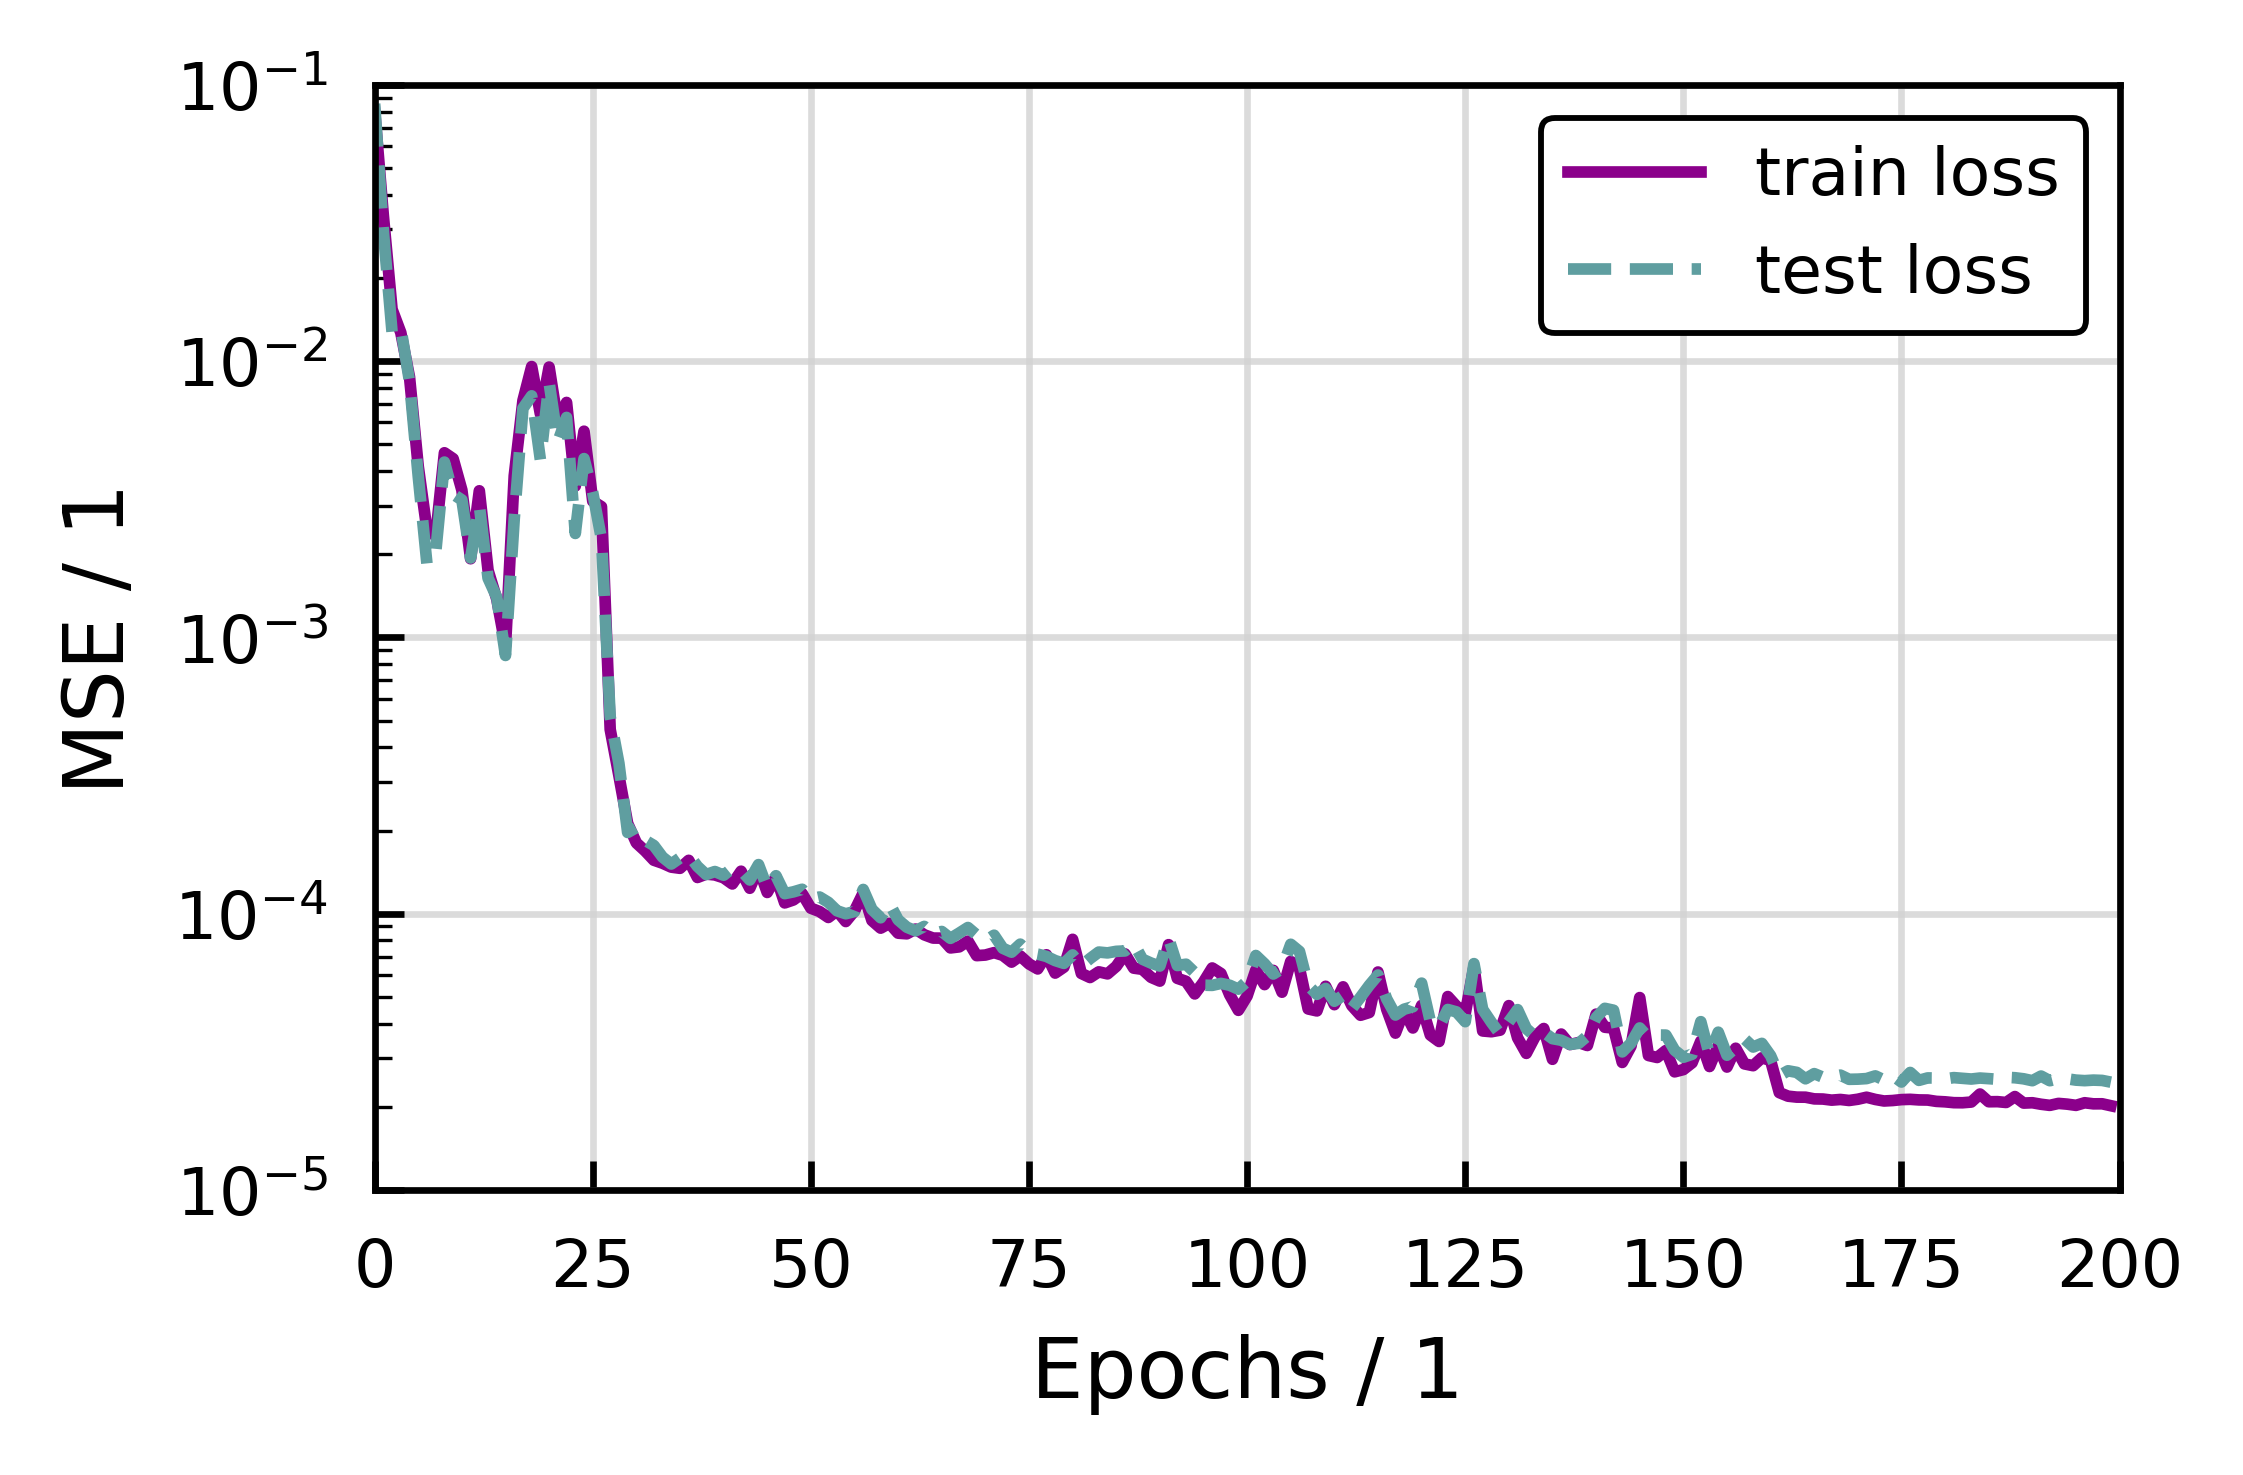

In [11]:
fig,ax = plt.subplots(figsize=(9.75*cm,6.5*cm))
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss,'--', label='test loss')
#plt.title("Train and Test Loss")
ax.set(xlabel = 'Epochs / 1', ylabel = 'MSE / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set(xlim=(0,200), ylim=(1e-5,1e-1))

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_001_learningcurve.png', bbox_inches = 'tight')
#np.savez('data/models/hyperparams/loss_005_020.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999869406959082 , R^2(NH3) = 0.9999719230914313
Test Dataset: R^2(H2) = 0.9999805452063252 , R^2(NH3) = 0.9999663463560856
Train R^2 gemittelt:  0.9999794318936698
Test R^2 gemittelt:  0.9999734457812054
Max Error Training: |x_H2 - x_H2,pred| = 0.006781210512093239 , |x_NH3 - x_NH3,pred| = 0.003607686786261305
Max Error Test: |x_H2 - x_H2,pred| = 0.00463104819492427 , |x_NH3 - x_NH3,pred| = 0.004272673615727557


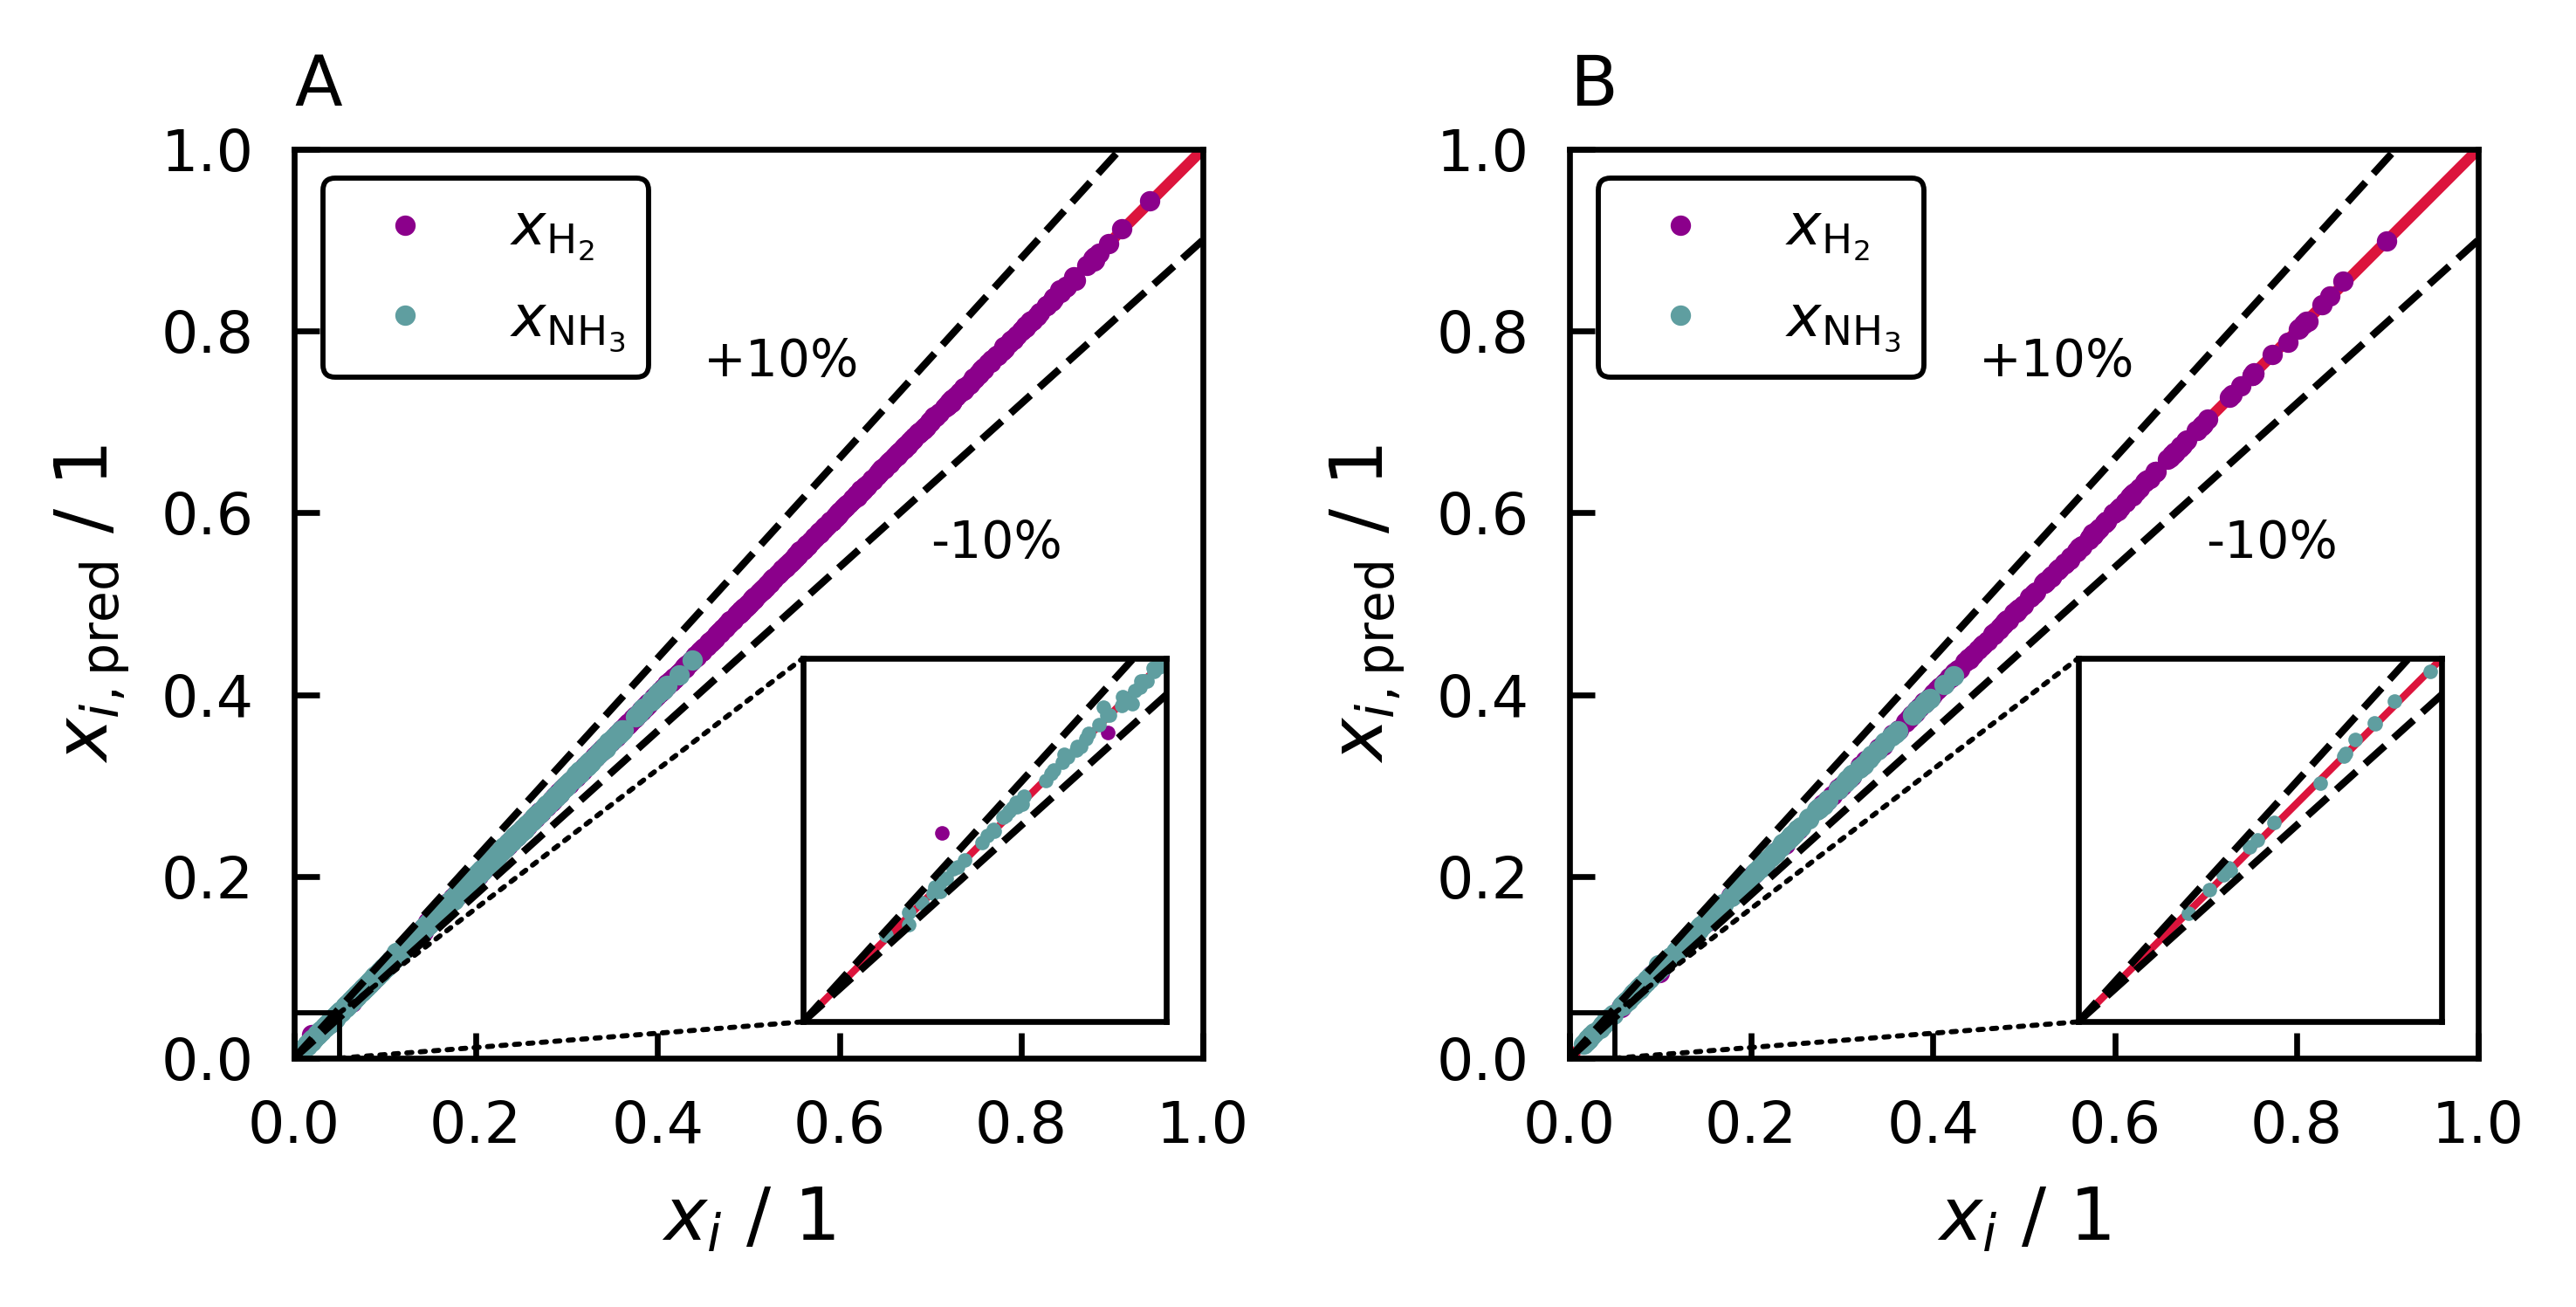

In [29]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Train R^2 gemittelt: ', (r2(x_H2_real,x_H2_pred)+r2(x_NH3_real,x_NH3_pred))/2)
print('Test R^2 gemittelt: ', (r2(x_H2_real_test,x_H2_pred_test)+r2(x_NH3_real_test,x_NH3_pred_test))/2)
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2)#, figsize =(13*cm,6.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")


ax[0].plot(x_H2_real, x_H2_pred, '.', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "-", color = 'crimson',lw=1.5 ,transform=ax[0].transAxes, zorder=1)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line

ax[0].text(0.45, 0.75, '+10%', fontsize=7)
ax[0].text(0.7, 0.55, '-10%', fontsize=7)
ax[0].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('A', loc='left')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#inset axes
x1,x2,y1,y2 = 0, 0.05, 0, 0.05 # subregion of origanal image
axin0 = ax[0].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin0.plot(x_H2_real, x_H2_pred, '.', markersize = 4)
axin0.plot(x_NH3_real, x_NH3_pred, '.', markersize = 4)
axin0.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box2= ax[0].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.05, 0.0), xyB=(0, 0), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.05, 0.05), xyB=(0, 1), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[0].add_patch(cp1)
ax[0].add_patch(cp2)


# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "-", color = 'crimson',lw=1.5 ,transform=ax[1].transAxes, zorder=1)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line
ax[1].text(0.45, 0.75, '+10%', fontsize=7)
ax[1].text(0.7, 0.55, '-10%', fontsize=7)
ax[1].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('B', loc='left')
ax[1].legend()

#inset axes
x1,x2,y1,y2 = 0, 0.05, 0, 0.05 # subregion of origanal image
axin1 = ax[1].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(x_H2_real_test, x_H2_pred_test, '.', markersize = 4)
axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax[1].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.05, 0.0), xyB=(0, 0), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.05, 0.05), xyB=(0, 1), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[1].add_patch(cp1)
ax[1].add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [30]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_002_parity.png', bbox_inches = 'tight')

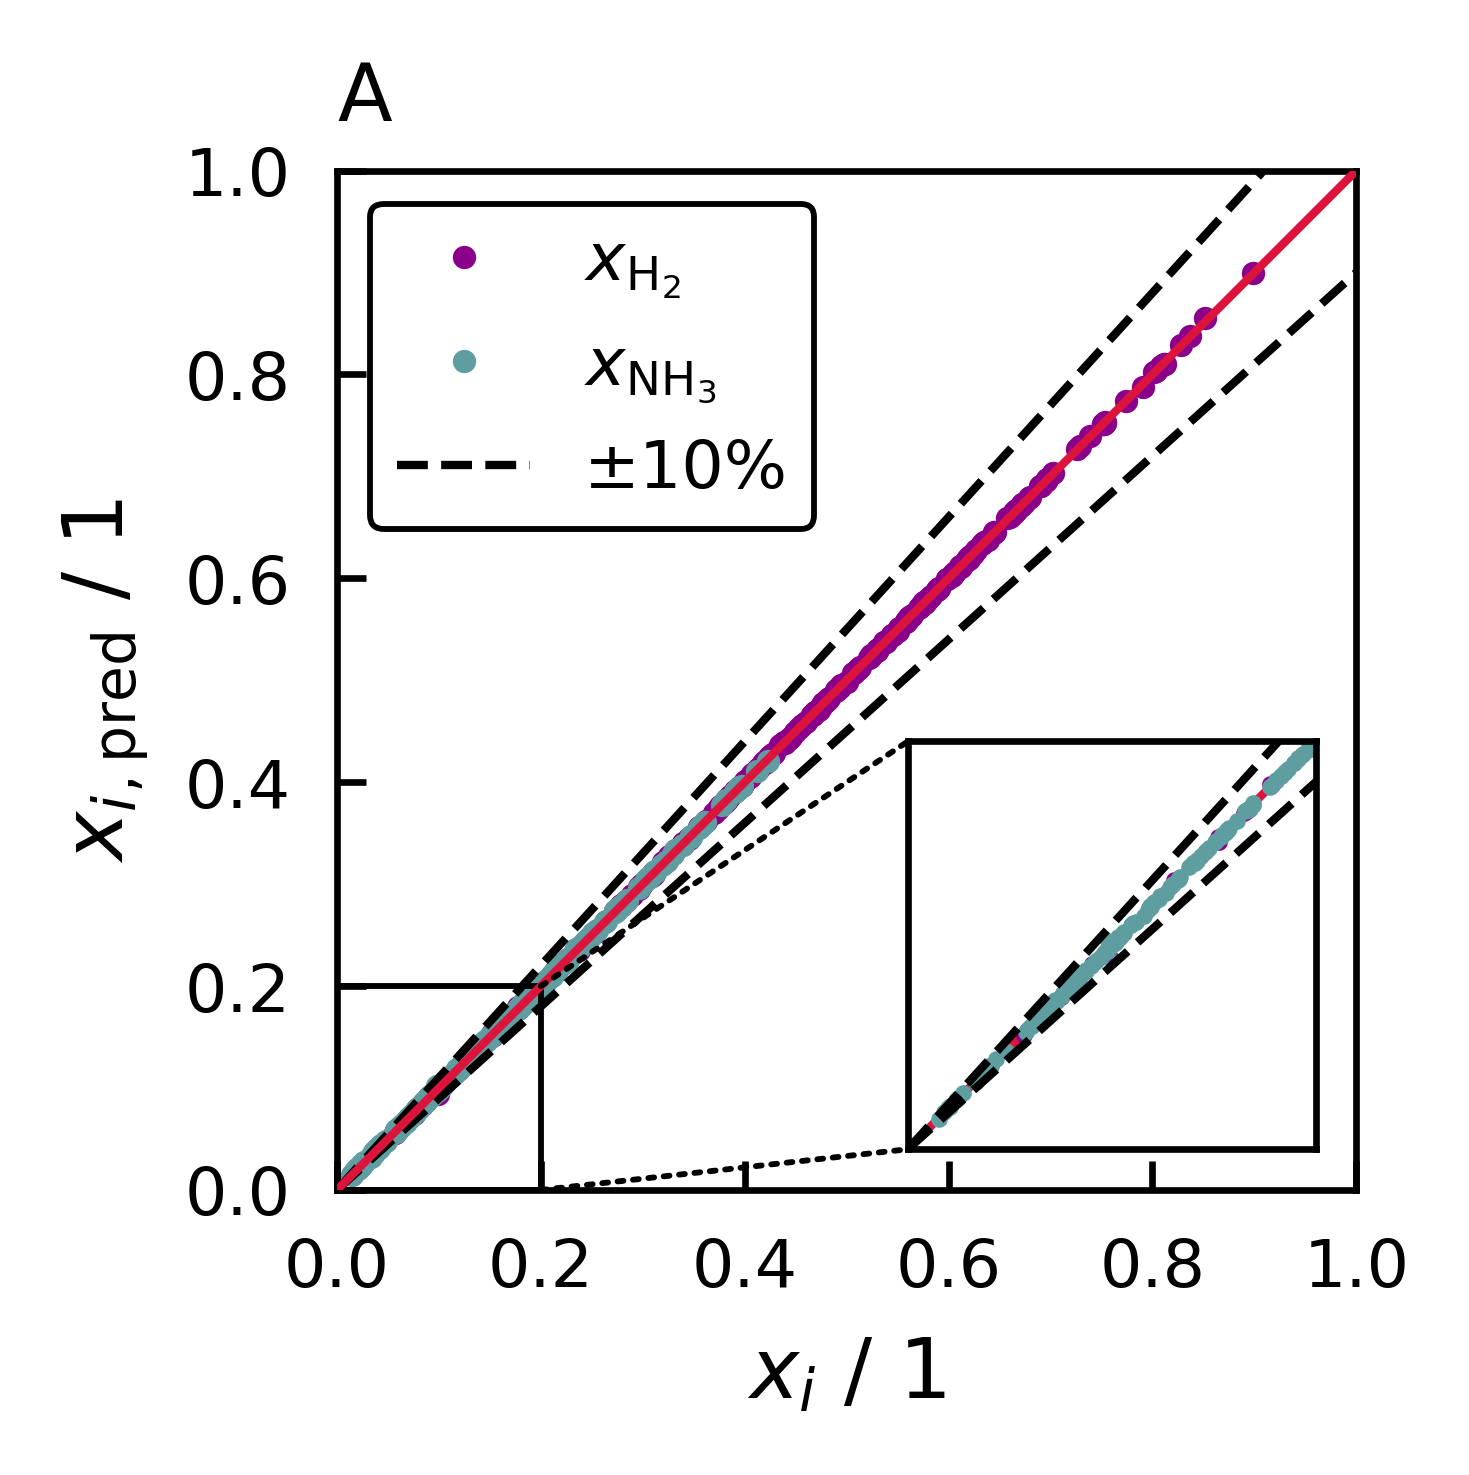

In [15]:
fig,ax = plt.subplots(figsize =(6.5*cm,6.5*cm))
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real_test, x_H2_pred_test, '.', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real_test, x_NH3_pred_test, '.', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1 ,transform=ax.transAxes, zorder=10)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", lw=1, label = ('\xb1' '10%')) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--",lw=1) # Error line
# ax.text(0.45, 0.75, '+10%', fontsize=7)
# ax.text(0.7, 0.55, '-10%', fontsize=7)
ax.set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('A', loc='left')
ax.legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin1 = ax.inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(x_H2_real_test, x_H2_pred_test, '.', markersize = 4)
axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax.indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.0), xyB=(0, 0), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax.add_patch(cp1)
ax.add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [16]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_020_parity_best.png', bbox_inches = 'tight')

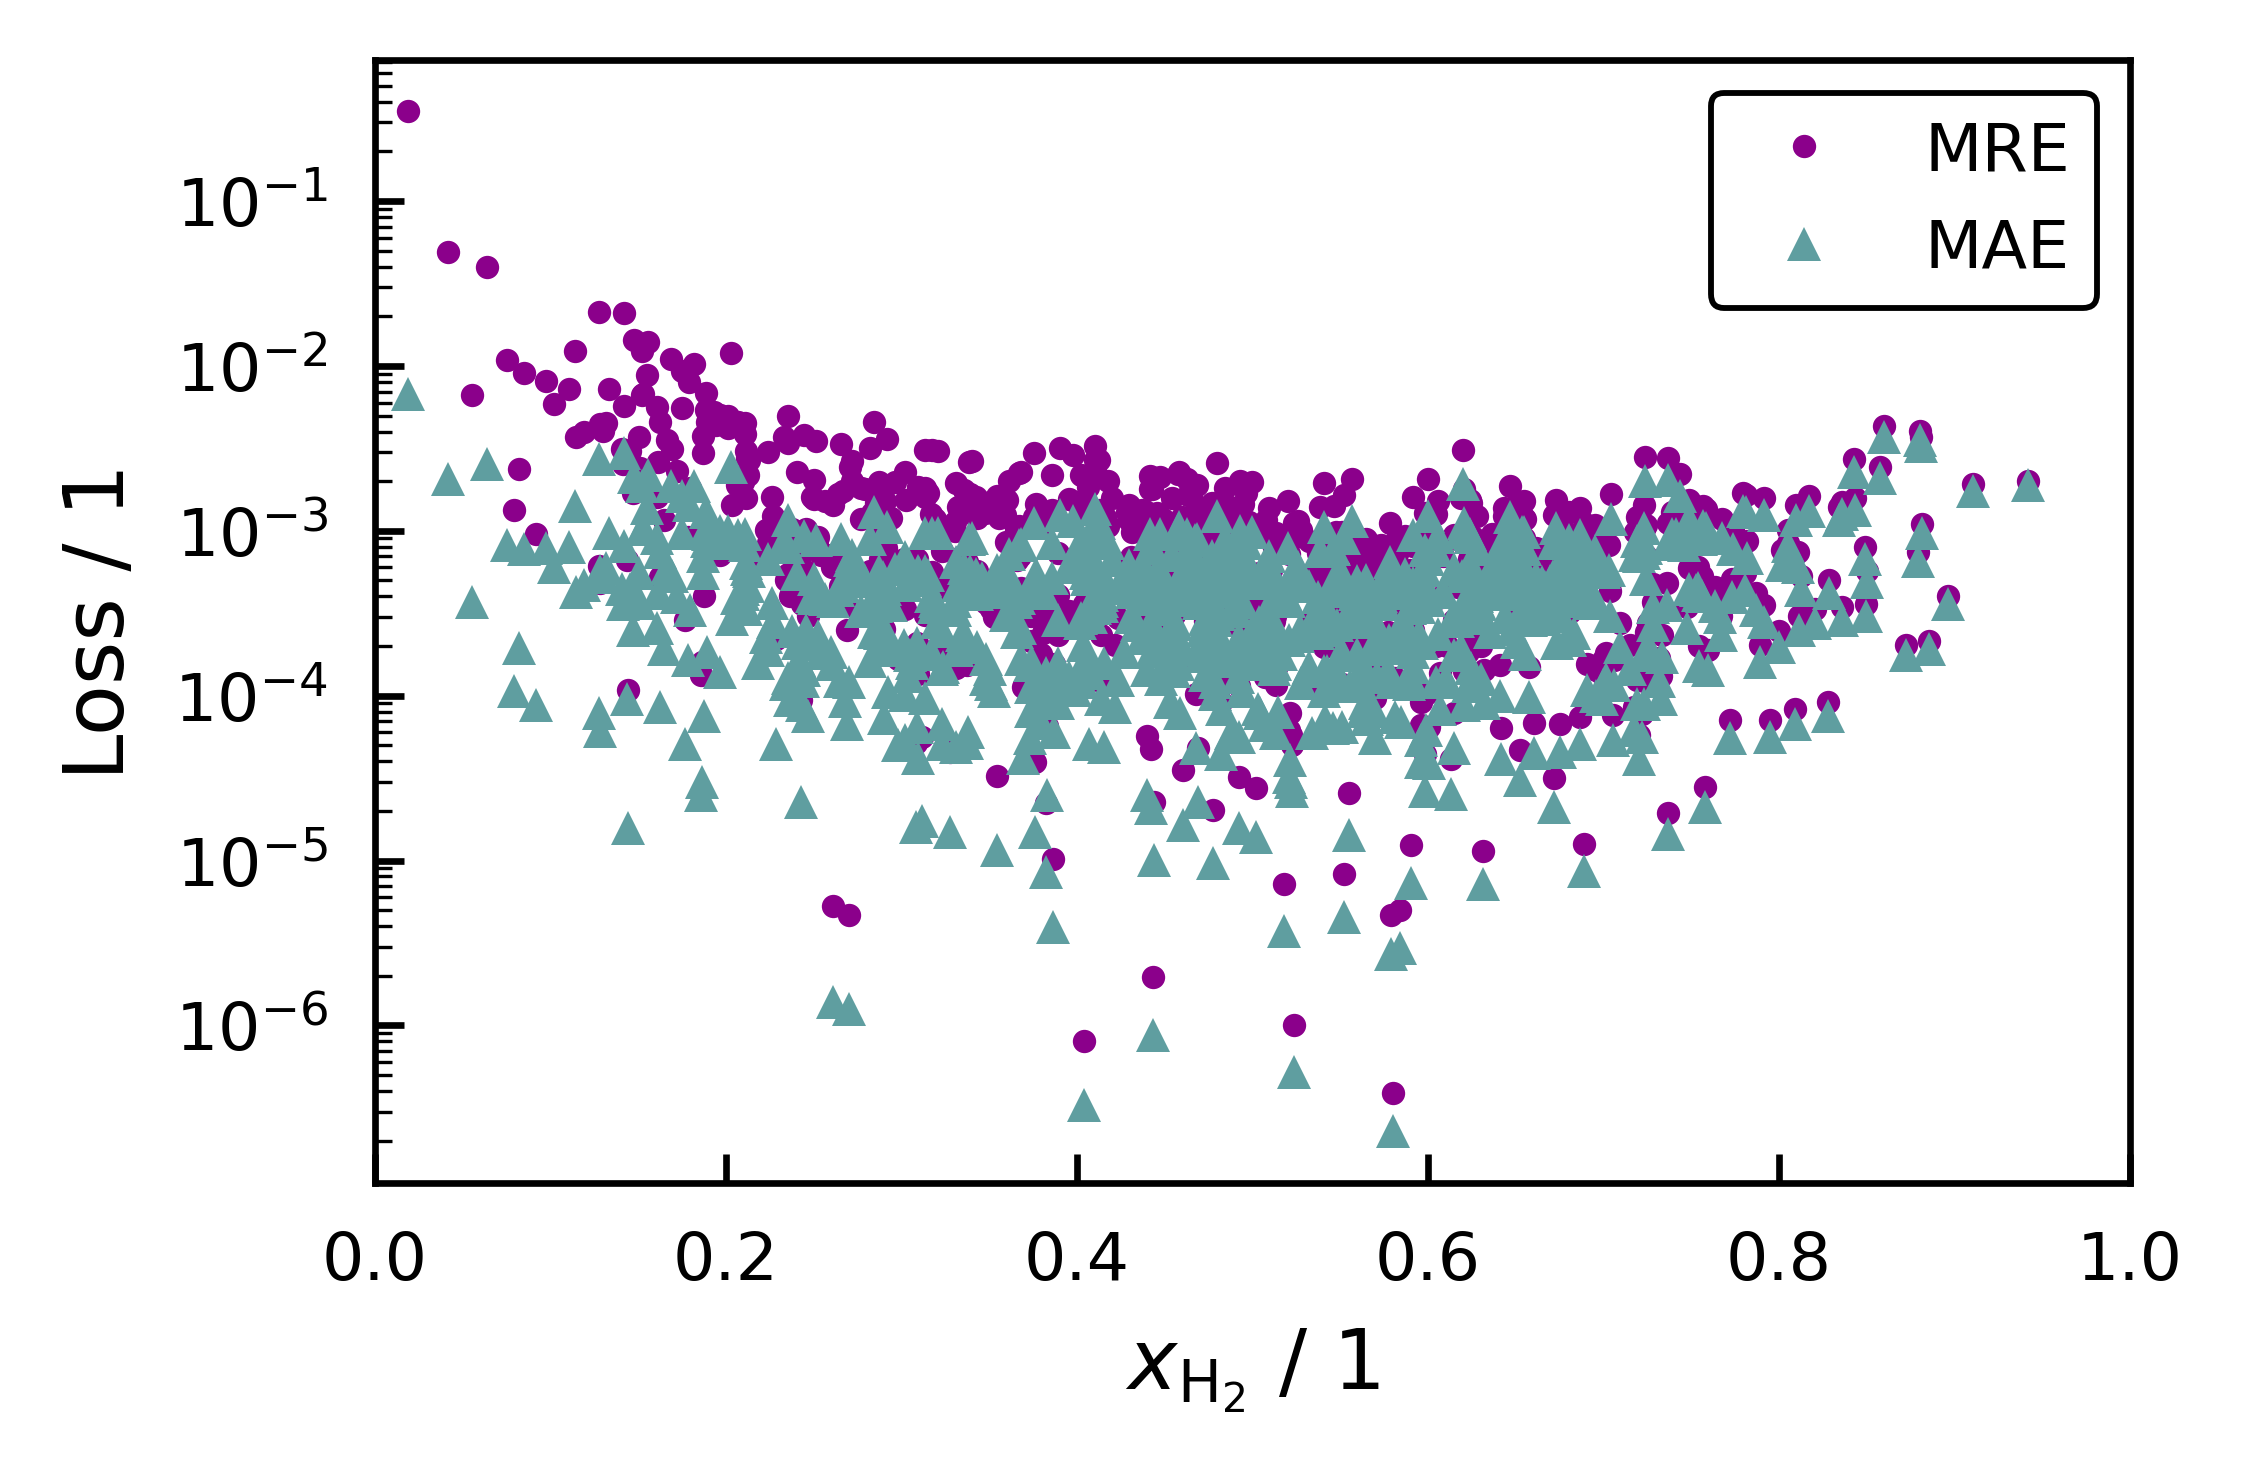

In [17]:
fig,ax = plt.subplots(figsize=(9.75*cm,6.5*cm))
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '^', markersize = 4, label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Loss / 1')
ax.set(xlim=(0,1))
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

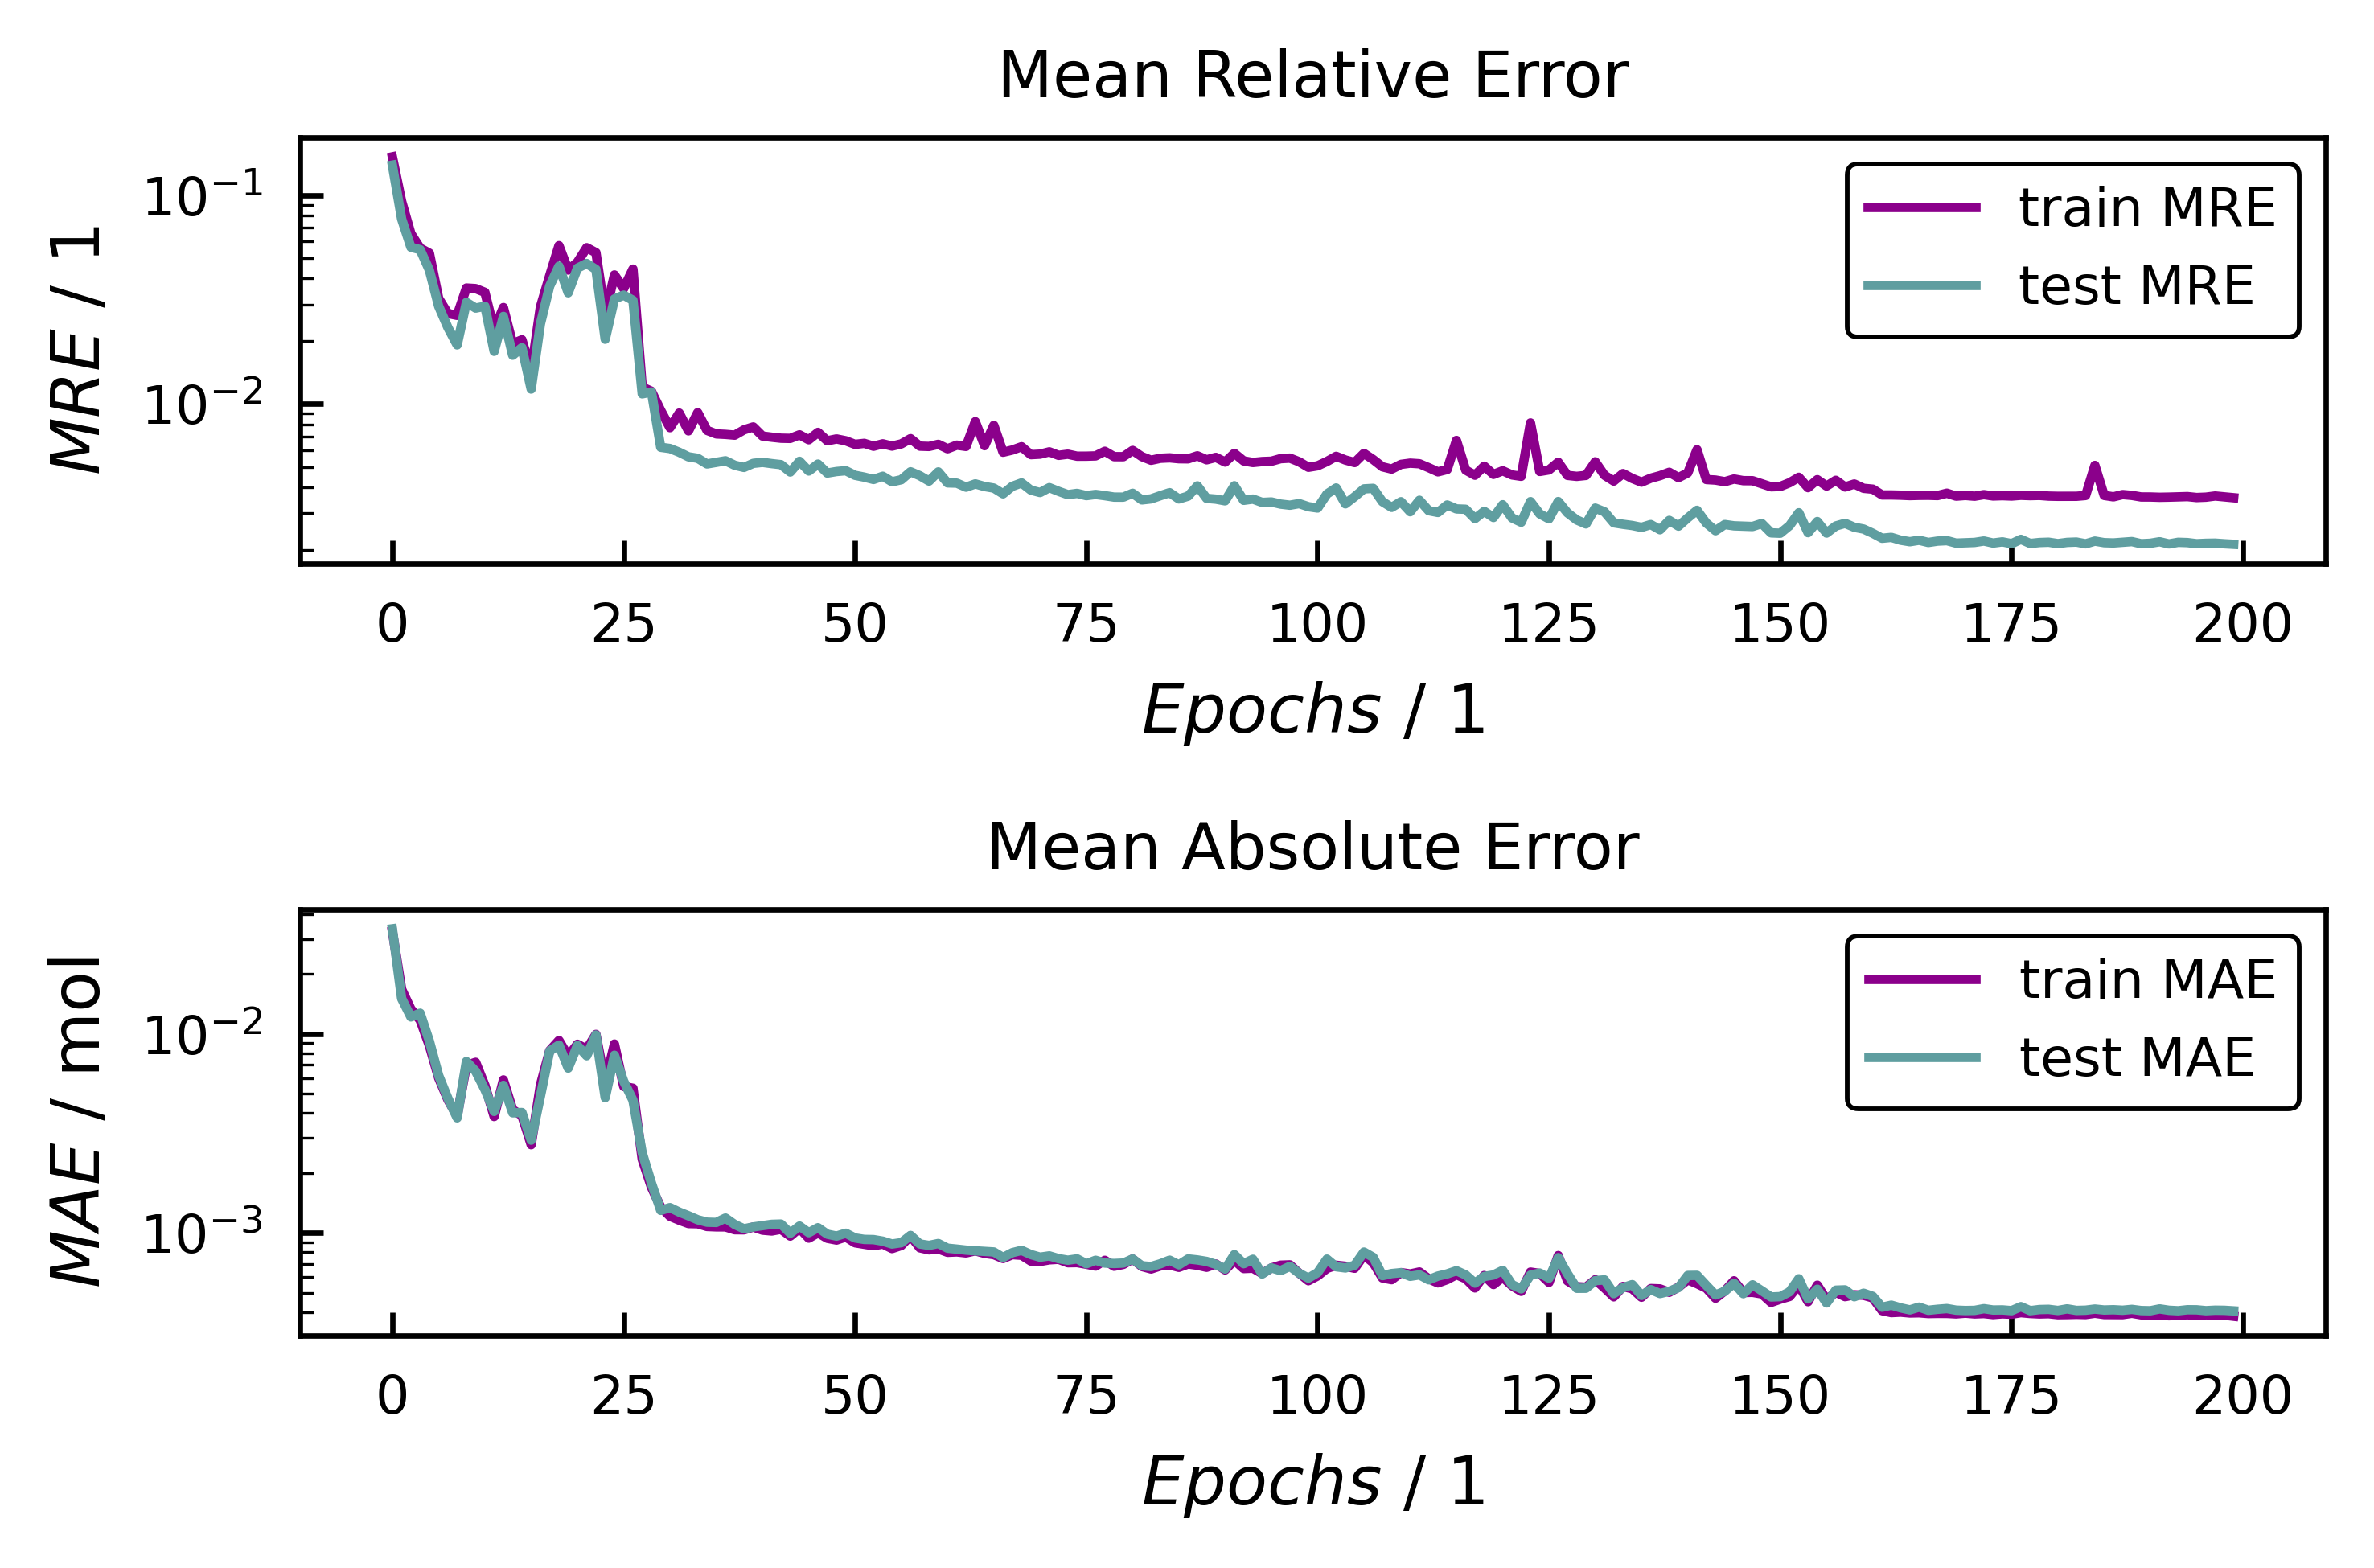

In [18]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

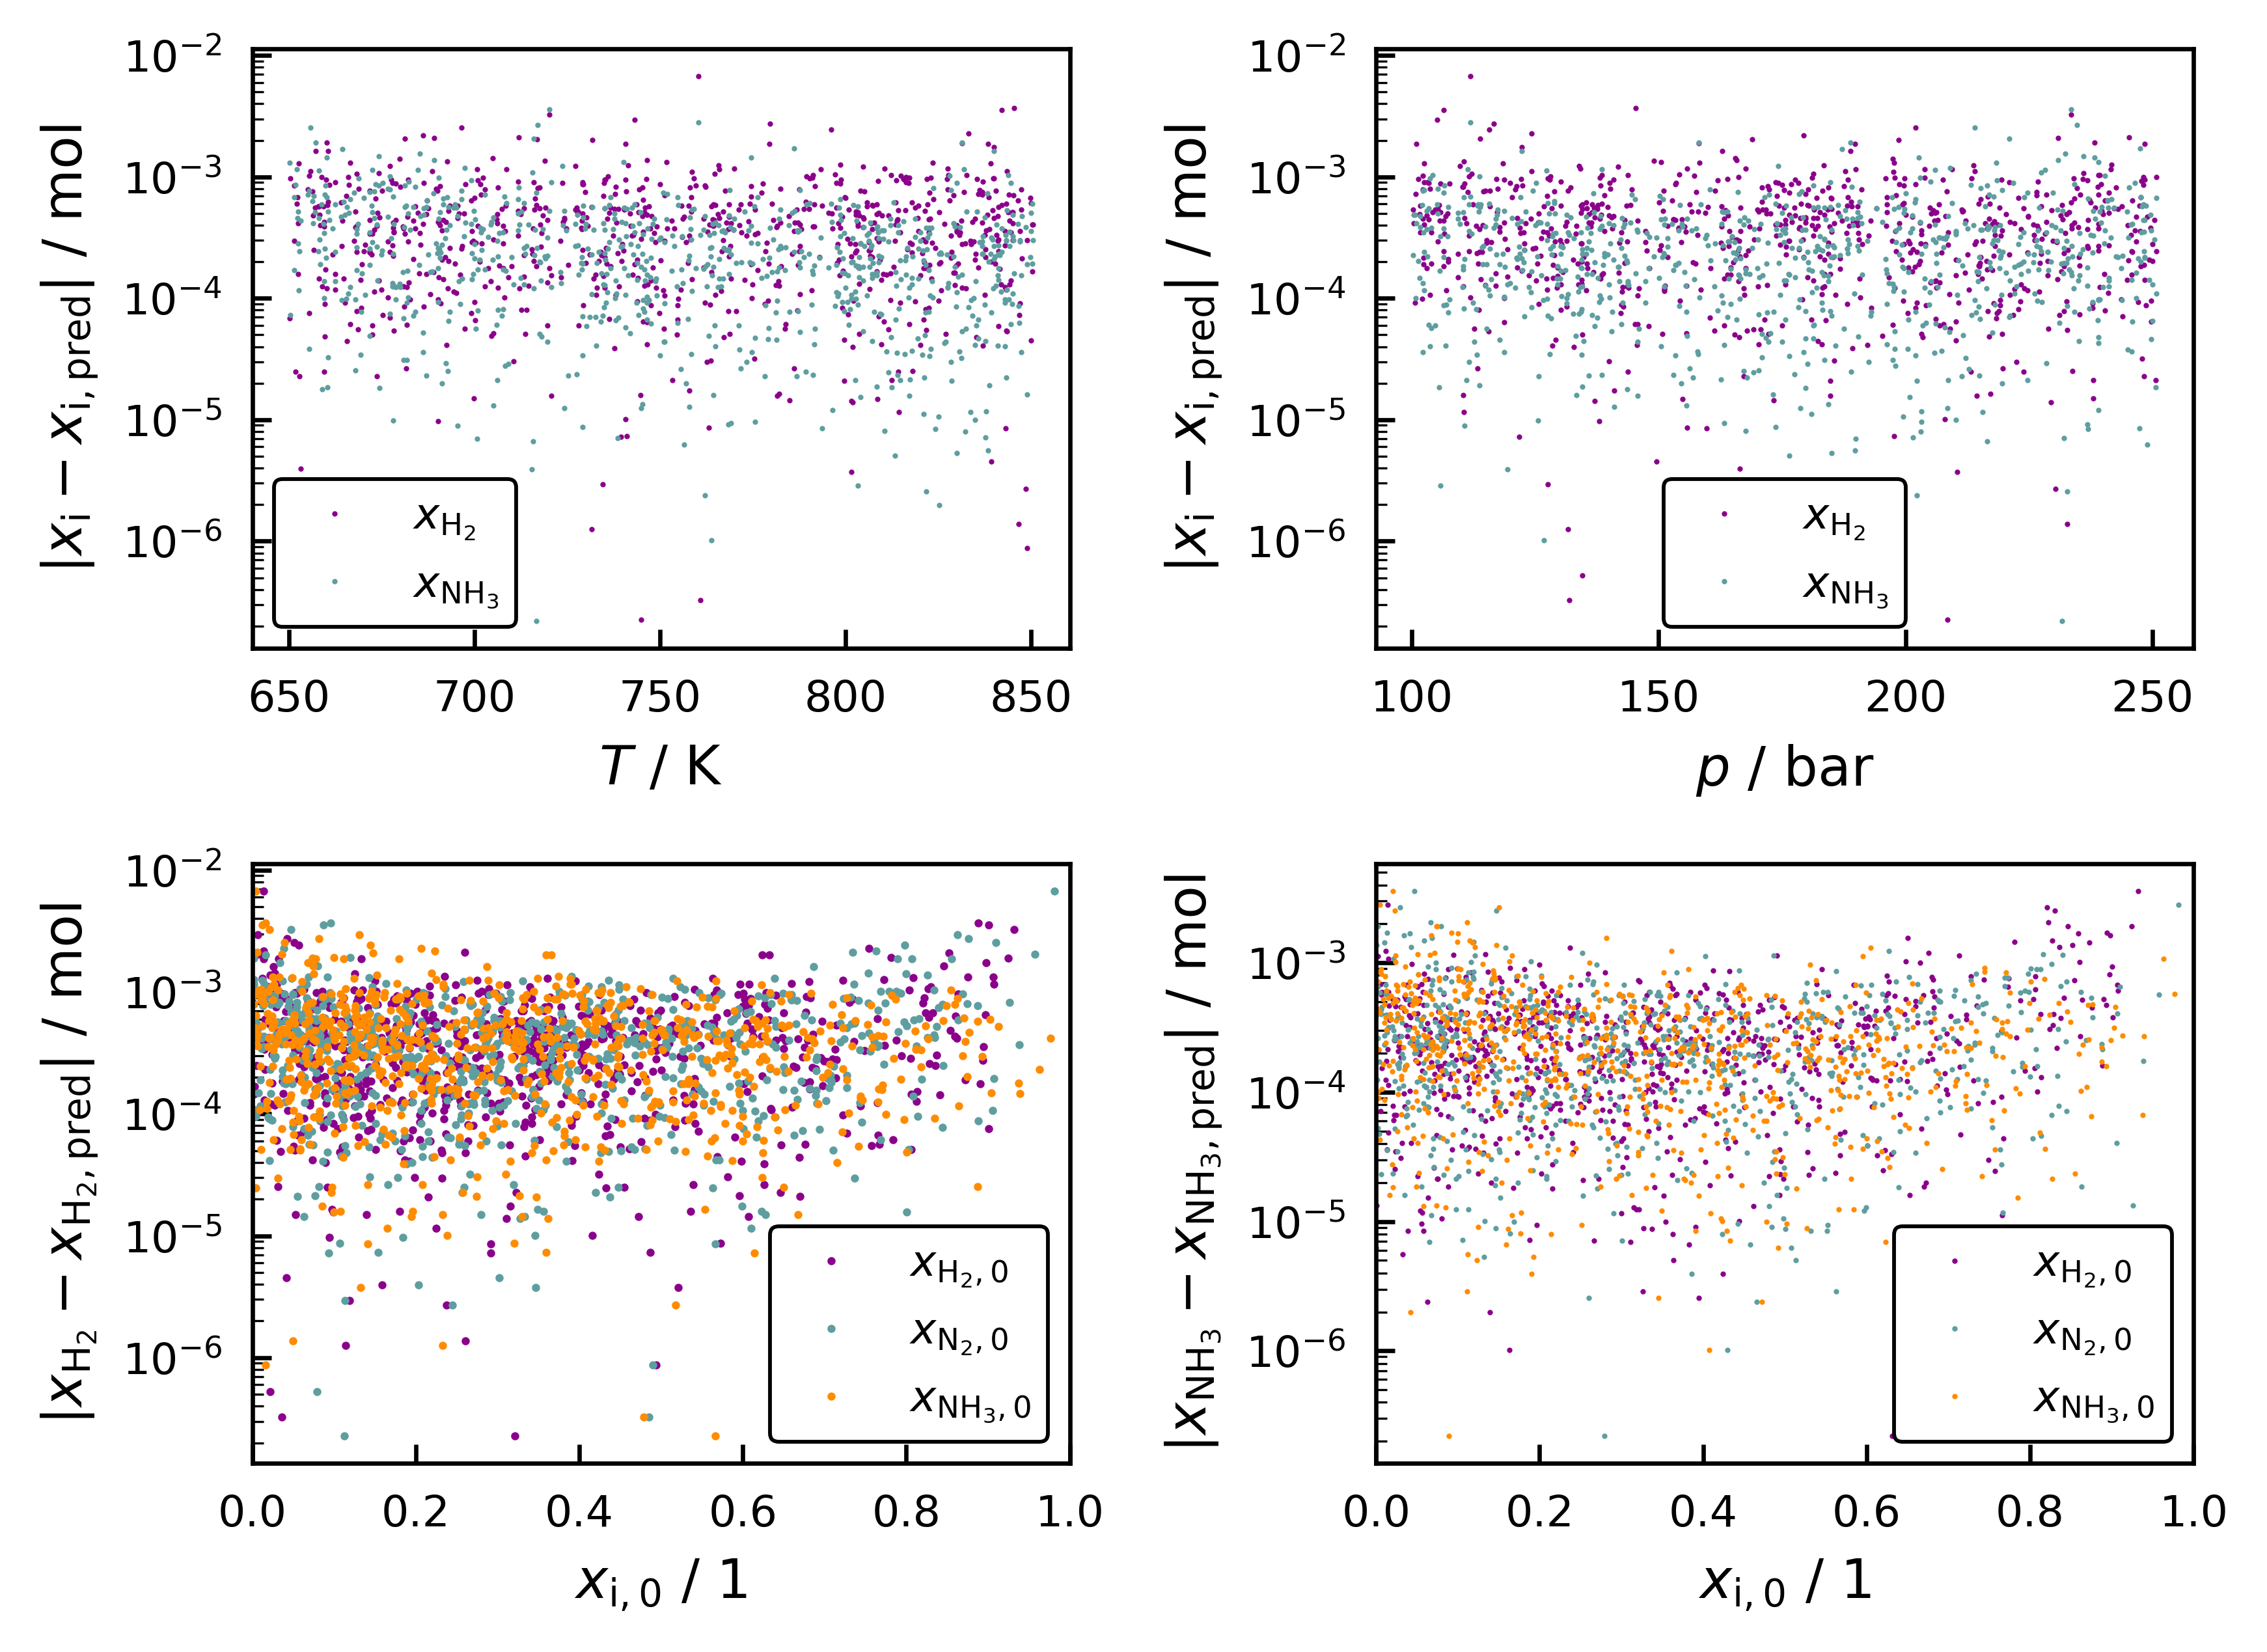

In [19]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (15*cm, 11*cm)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 3, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 3, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 3, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

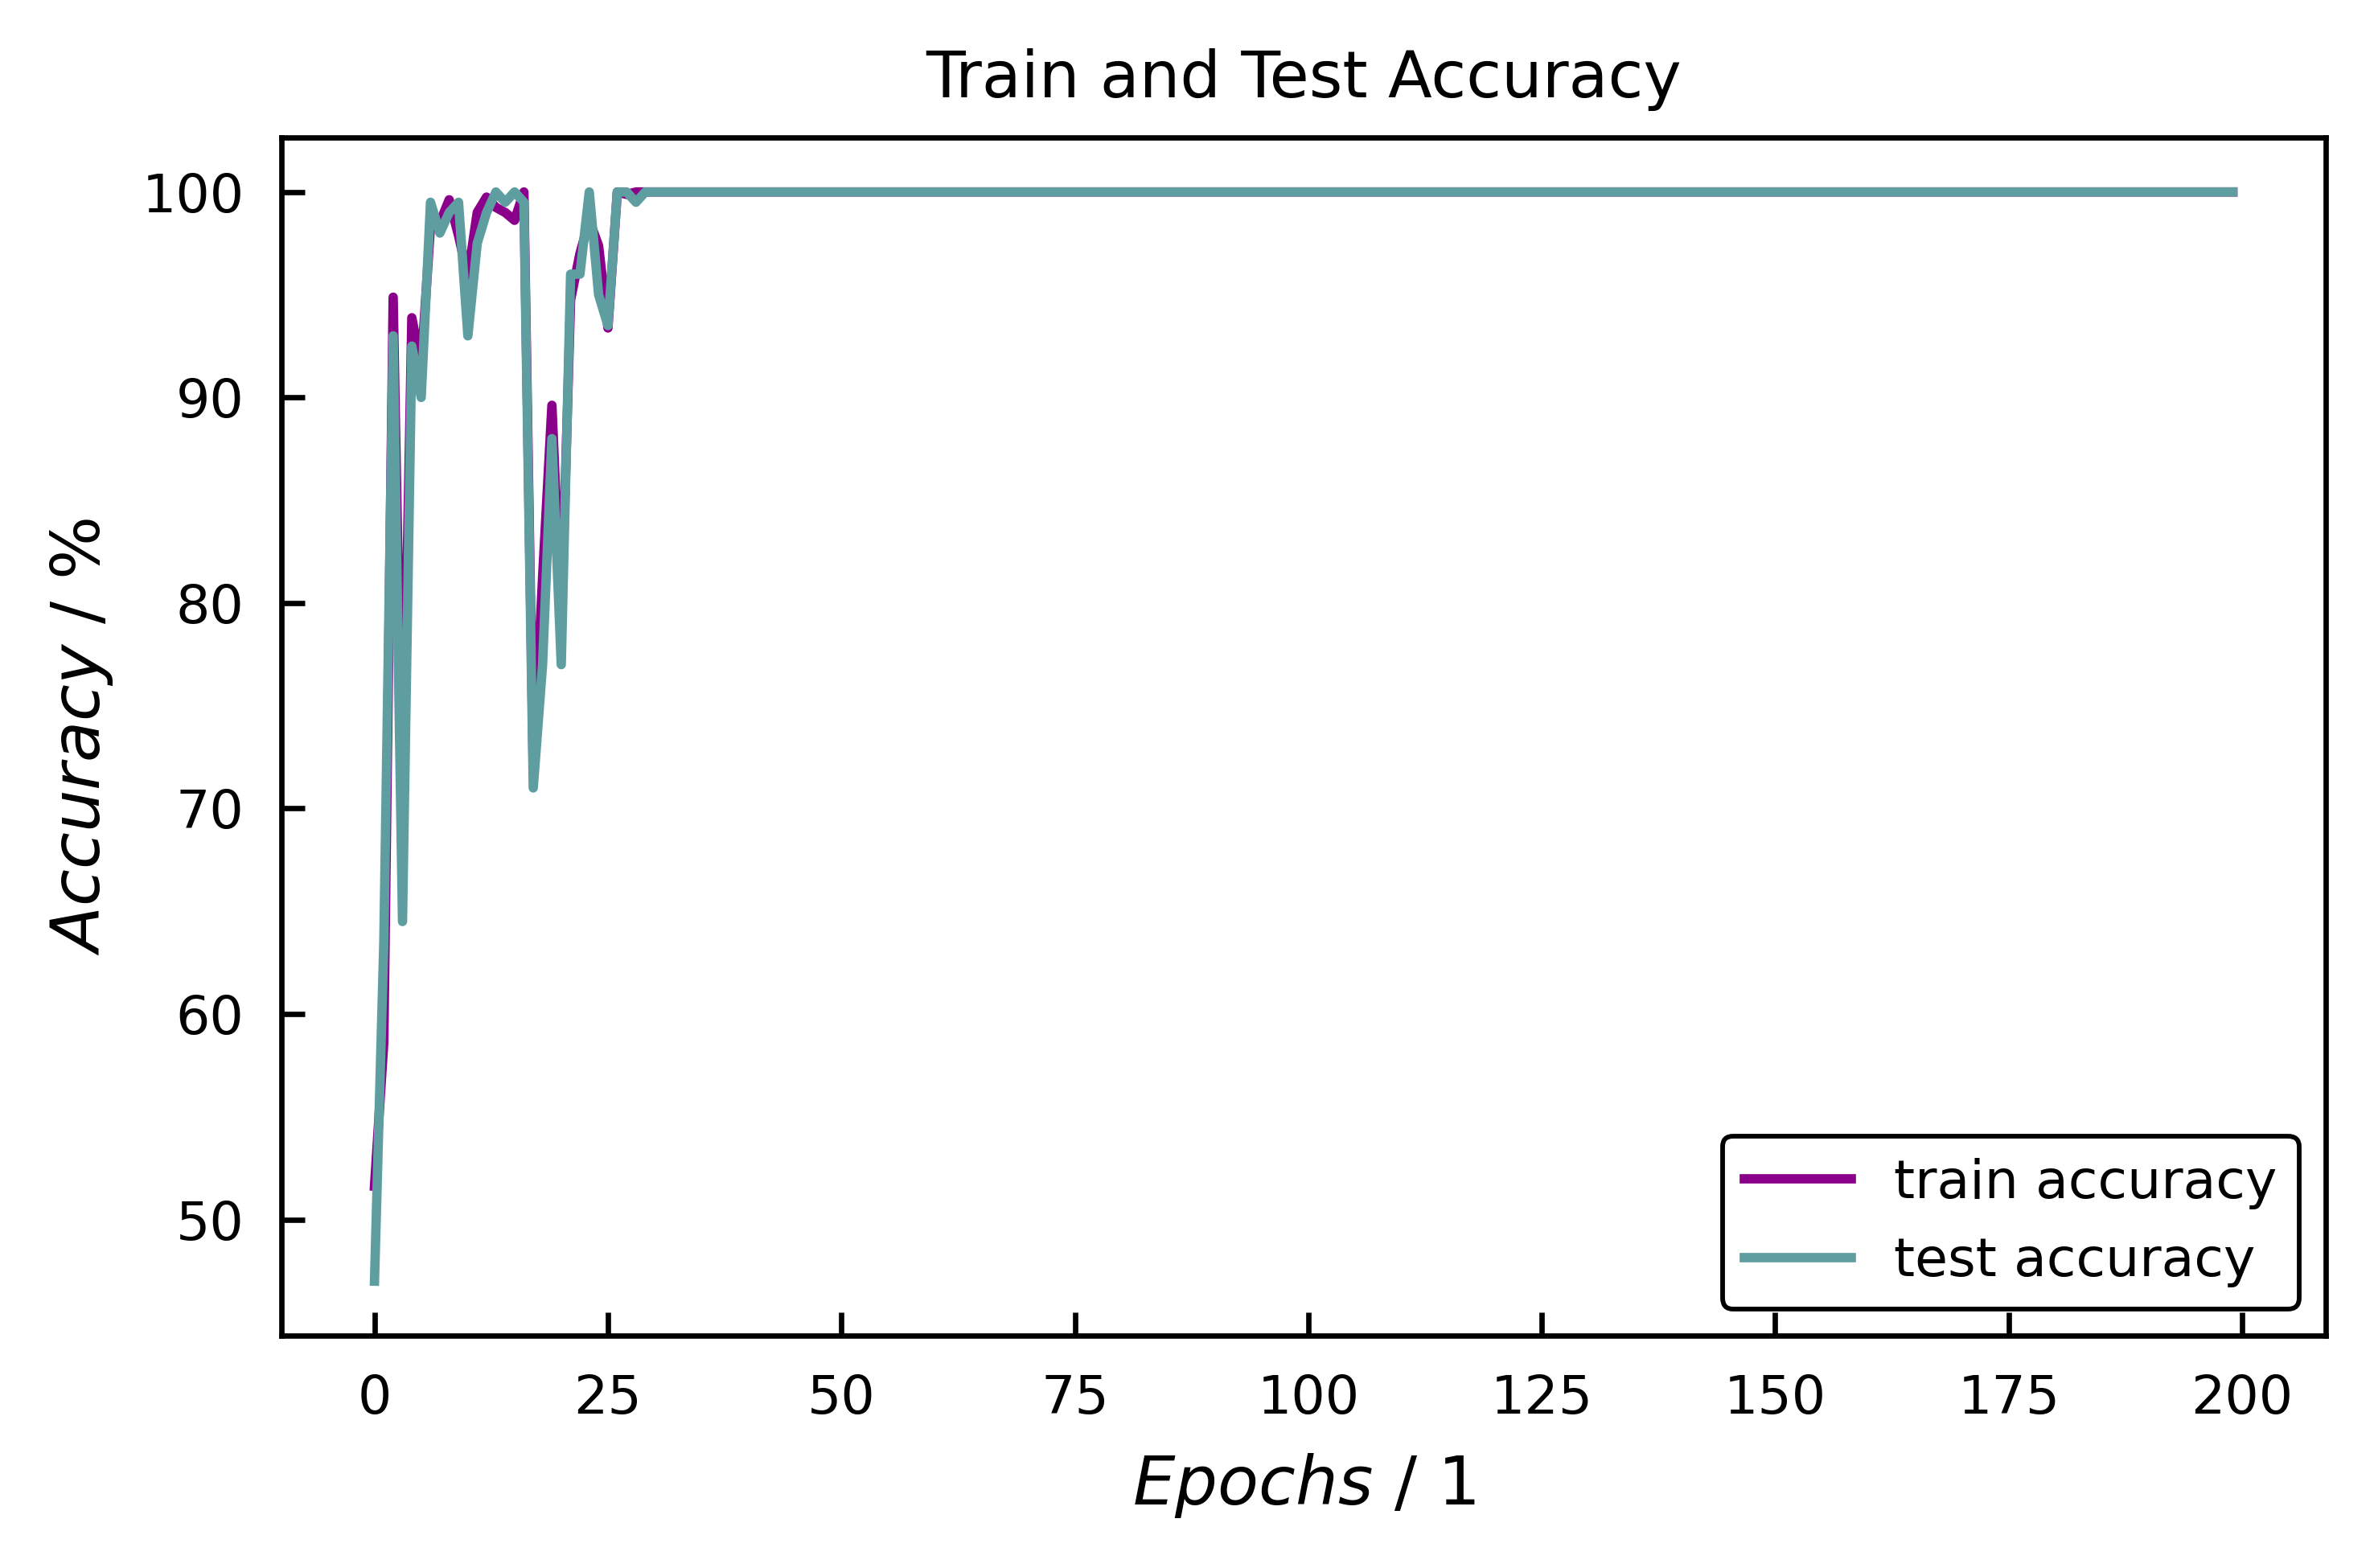

In [20]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [21]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.125 s


#### Debugging Hilfe

In [22]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 2.3532e-01, -2.7843e-01, -5.9243e-01,  9.0409e-01, -3.4264e-01],
        [ 4.5242e-01, -2.1289e-01, -8.7578e-01,  6.0068e-01,  2.4553e-01],
        [ 1.5181e+00, -1.1482e+00, -1.0569e+00,  1.9644e+00, -9.7054e-01],
        [ 1.5021e+00,  2.8137e-01, -1.3550e+00,  7.8357e-01,  5.2888e-01],
        [ 2.1431e-01, -8.9262e-01, -3.7919e-02, -1.1237e+00,  1.1857e+00],
        [ 9.2303e-01, -1.1778e-01, -1.1215e+00,  9.6405e-01,  1.1525e-01],
        [-7.5285e-02,  1.1237e+00,  1.7720e+00, -9.2834e-01, -7.9016e-01],
        [-1.1362e+00, -1.1689e+00, -5.0226e-01,  3.1843e-01,  1.6746e-01],
        [ 1.2716e+00,  1.2730e-01, -5.1956e-01, -1.0607e+00,  1.5940e+00],
        [ 1.2455e+00,  6.1265e-01, -3.4615e-01,  1.4212e-01,  1.9445e-01],
        [ 8.7066e-01,  1.0656e+00, -7.6539e-01, -2.6253e-01,  1.0195e+00],
        [-9.5612e-01,  9.8330e-01,  2.4496e+00, -1.1231e+00, -1.2561e+00],
        [-9.1929e-01, -9.3665e-01, -1.0869e+00, -4.7171e-01,  1.5488e+00],
        [-2.5528e-01,  1.

#### Einblick in Netzwerk

In [23]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.0534,  0.3290,  0.1667,  0.3395, -0.0946],
         [-0.2576, -0.2107, -0.1590, -0.2326, -0.2074],
         [ 0.2711, -0.2837,  0.3868, -0.2762, -0.0679],
         [ 0.1471, -0.3314,  0.0080,  0.2307,  0.1788],
         [-0.3165,  0.2470,  0.2243, -0.1914, -0.1890],
         [-0.0235, -0.4643, -0.3665, -0.2868, -0.4186],
         [-0.0007,  0.0206,  0.2543,  0.4439,  0.0961],
         [ 0.3754,  0.3131, -0.1208, -0.2184,  0.2144],
         [-0.3918,  0.3285, -0.3521,  0.4292, -0.3894],
         [ 0.2111, -0.1028,  0.3802, -0.2791,  0.1956],
         [ 0.3976, -0.2543, -0.4188, -0.2869, -0.2015],
         [-0.1831,  0.0723, -0.2033,  0.1898, -0.2122],
         [ 0.0089, -0.0478, -0.0356,  0.2880, -0.2966],
         [ 0.0742, -0.2644, -0.0754,  0.0726,  0.2038],
         [ 0.2726, -0.2301,  0.1270, -0.3574,  0.1326],
         [-0.2301,  0.2456,  0.3191,  0.0127,  0.0644],
         [ 0.2460,  0.3092,  0.2197,  0.2798,  0.3249],
         [-0.2427,  0.348

In [24]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0811, 0.3303, 0.2126, 0.7080, 0.2796],
        [0.8006, 0.5102, 0.2970, 0.8718, 0.7132]])
tensor([[-0.2692,  0.0316],
        [-0.0622, -0.4280]], grad_fn=<AddmmBackward0>)


In [25]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [26]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-8.9402e-01, -1.4855e+00,  4.1441e-01,  2.8434e-01, -6.9731e-01],
        [-1.2618e+00, -1.5746e+00, -2.2816e-01,  1.3899e-01,  8.1845e-02],
        [-1.3796e+00,  1.3841e+00,  2.1320e+00, -1.1431e+00, -9.2400e-01],
        [-1.0988e+00,  3.3980e-01,  1.9629e+00, -7.2544e-01, -1.1849e+00],
        [ 4.0981e-01,  1.6669e+00, -1.3793e+00,  1.9584e+00, -6.4803e-01],
        [-6.6966e-01,  9.3490e-01, -9.2039e-01,  7.0648e-01,  1.8117e-01],
        [ 1.2191e+00, -7.4080e-02, -7.8744e-01,  1.9417e+00, -1.2118e+00],
        [-9.4129e-01,  1.6363e+00, -9.0395e-01,  7.0352e-01,  1.6808e-01],
        [-1.7763e-01,  7.5343e-01, -5.2777e-02, -9.1972e-01,  9.9182e-01],
        [-1.6306e+00, -7.2507e-01, -1.0438e+00, -3.1388e-01,  1.3452e+00],
        [ 1.4755e+00, -1.5753e+00,  2.4516e+00, -1.0261e+00, -1.3571e+00],
        [-1.6774e-01,  7.9365e-01,  1.1079e+00, -3.9540e-01, -6.8316e-01],
        [ 9.0362e-01, -1.1231e+00,  5.8435e-02,  4.1354e-01, -4.8001e-01],
        [-1.6580e+00,  1.

tensor([[-5.7869e-01, -1.3967e+00,  1.2310e+00,  1.0511e+00, -3.0662e-01],
        [-9.7390e-01, -1.4134e+00,  4.7859e-01,  9.9449e-01,  9.1419e-01],
        [-9.6051e-01,  9.4447e-01,  1.4600e+00, -7.9747e-01, -6.4647e-01],
        [-8.0885e-01,  4.0640e-01,  1.7776e+00, -4.9348e-01, -8.8164e-01],
        [ 6.4063e-03,  9.8220e-01, -1.3824e+00,  1.2085e+00, -8.1474e-01],
        [-9.7624e-01,  1.2110e+00, -1.3180e+00,  8.9966e-01,  1.8358e-01],
        [ 8.3969e-01, -2.4445e-01, -8.4250e-01,  1.4455e+00, -1.1983e+00],
        [-1.0941e+00,  1.5322e+00, -1.0561e+00,  5.8178e-01,  3.6210e-02],
        [-4.3172e-01,  9.2326e-01, -2.5002e-01, -1.5117e+00,  1.2702e+00],
        [-1.1500e+00, -2.4992e-01, -5.6679e-01,  1.5879e-01,  1.8079e+00],
        [ 8.9969e-01, -9.5262e-01,  1.4923e+00, -6.1920e-01, -8.2017e-01],
        [-4.2924e-01,  9.5188e-01,  1.4033e+00, -7.5630e-01, -1.1697e+00],
        [ 1.3497e+00, -1.5324e+00,  1.4780e-01,  6.5279e-01, -6.1793e-01],
        [-1.4581e+00,  1.

#### Histogramme Verteilung von $xi$ und $x{_i}$

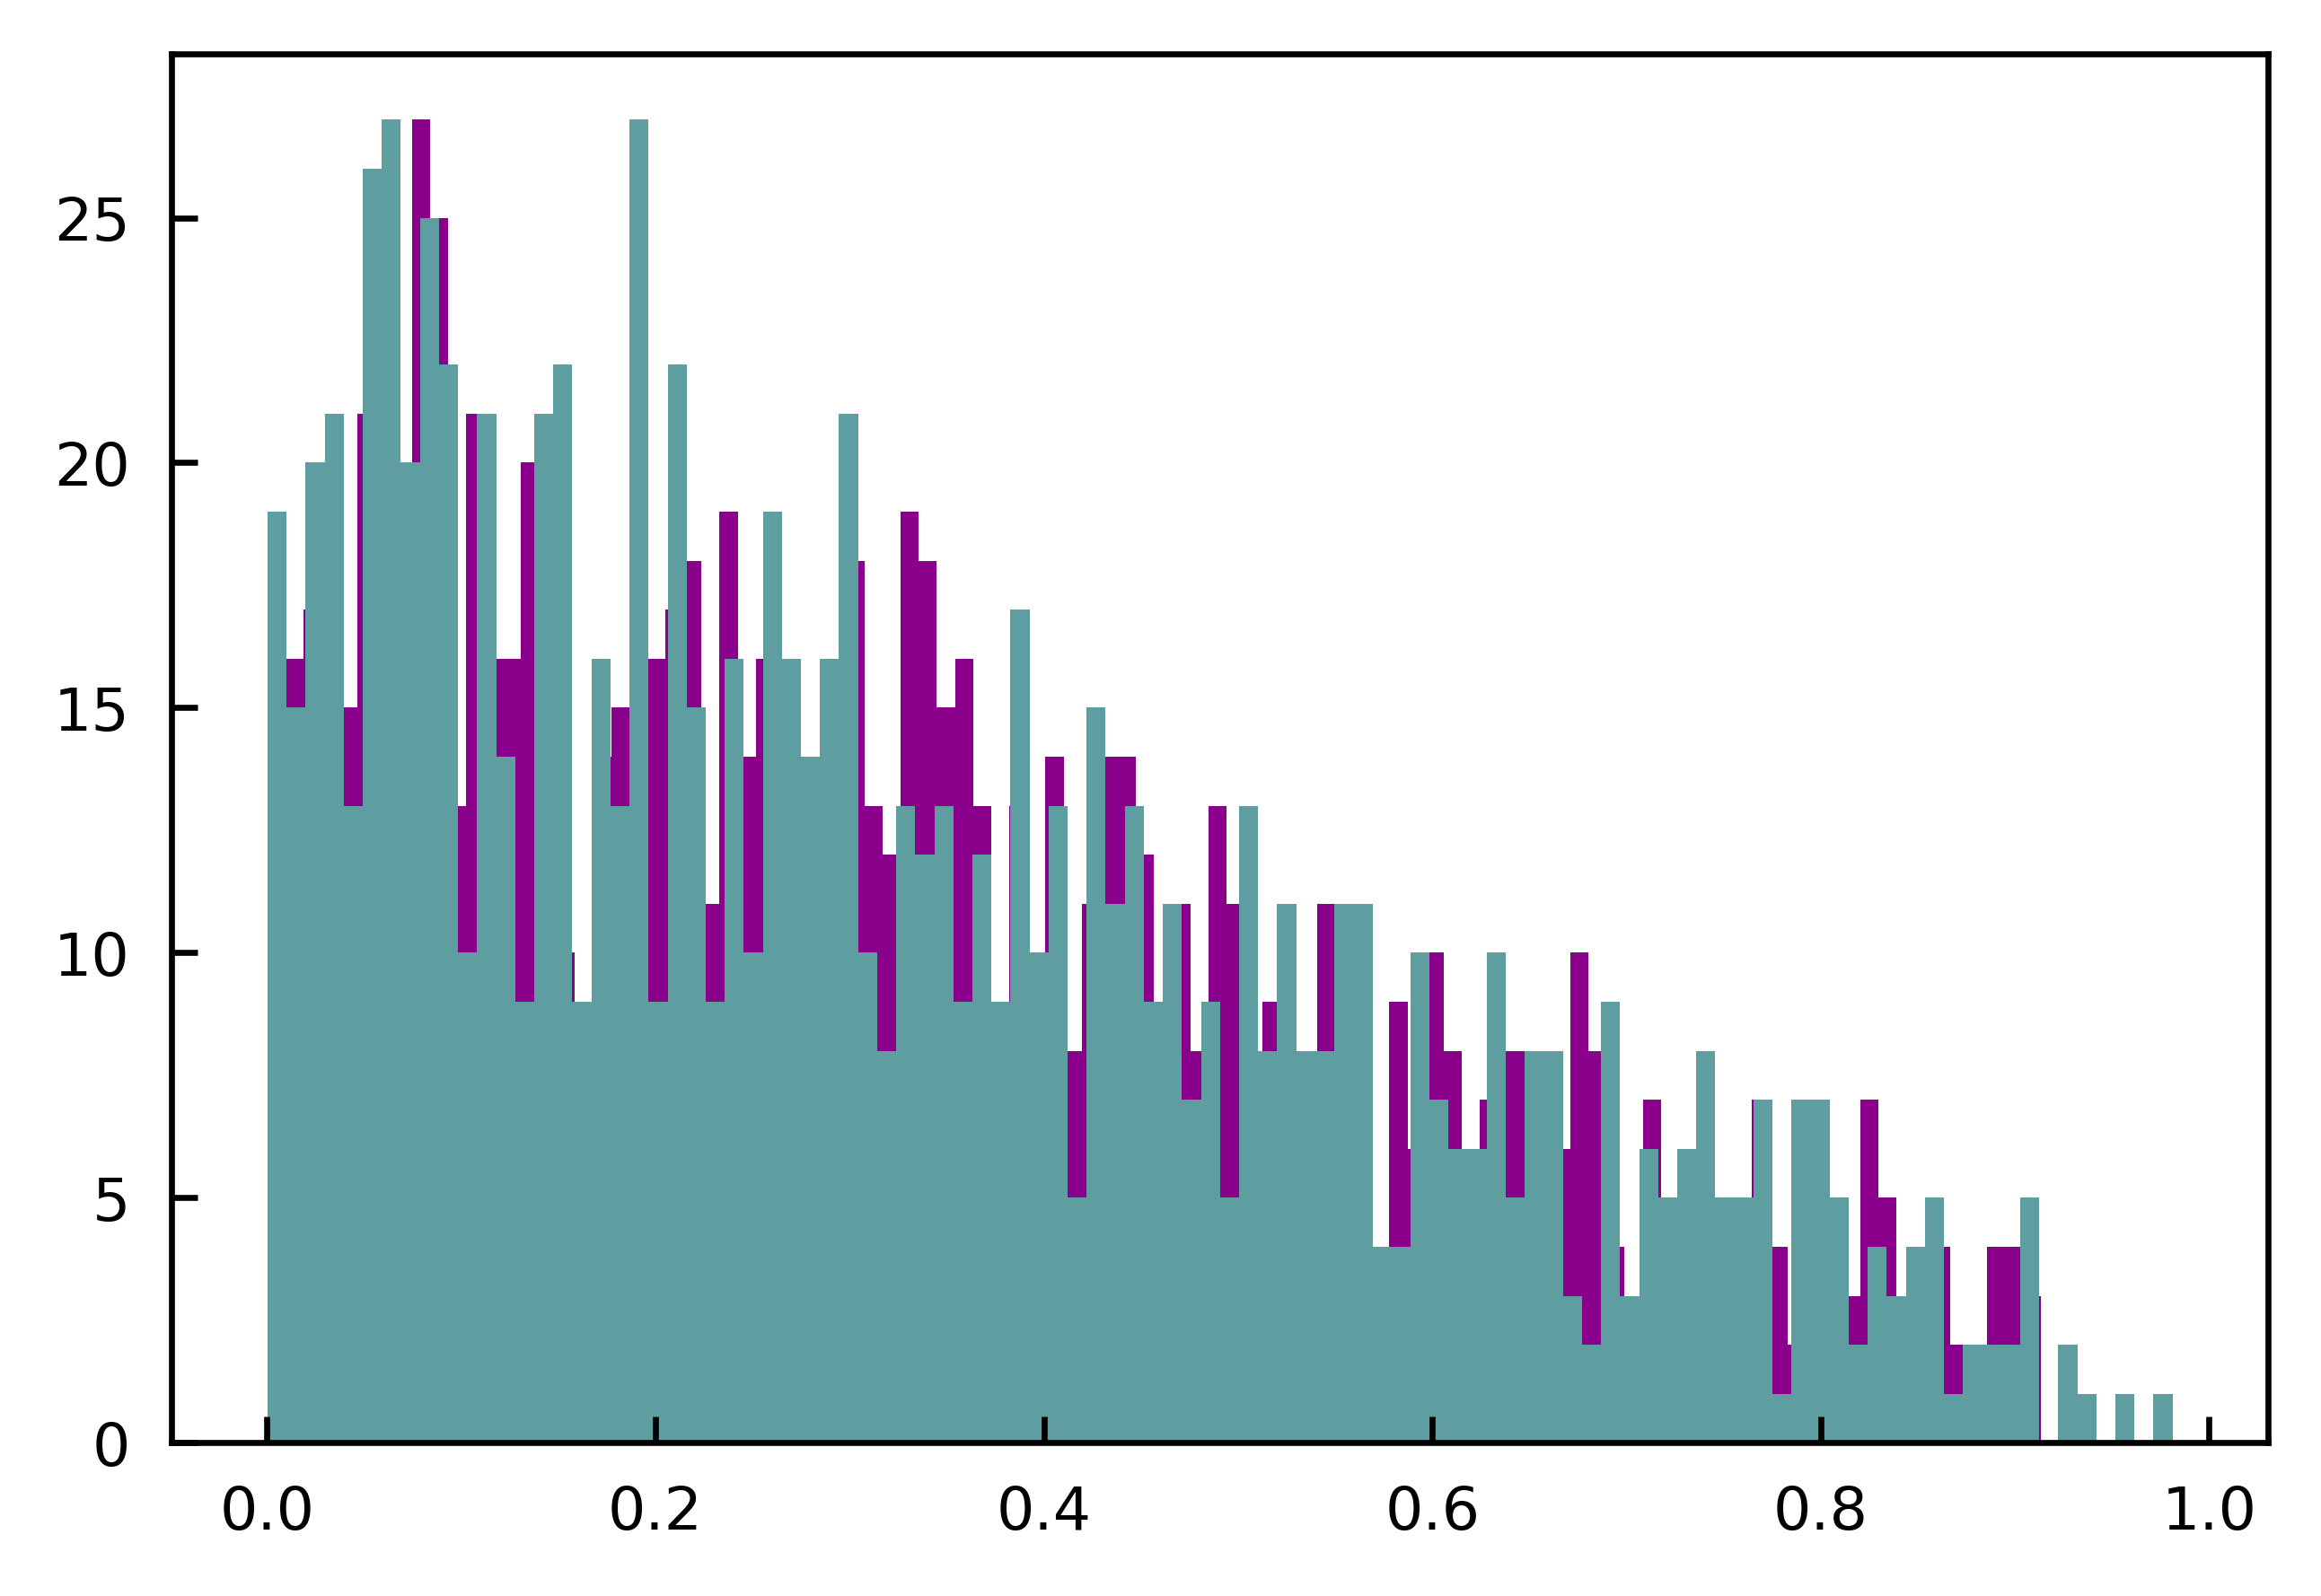

In [27]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [28]:
# torch.save(net.state_dict(),'data/models/ann_005_020.pth')
#np.savez('data/models/params_005_020.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)